In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind,chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay,f1_score,recall_score,precision_score
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [3]:
lt_data =pd.read_csv('logistic_regression.csv')
df = lt_data.copy()
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
pd.set_option('display.max_columns', None)

 **Exploration of data :**

In [5]:
df.shape

(396030, 27)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [7]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

  **Statistical Summary**

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [9]:
df.describe(include='object').T

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+ years,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-2014,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


 **Duplicate Detection**

In [10]:
df[df.duplicated()]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address


Insights
*   The dataset does not contain any duplicates.




 **Null Detection**

In [12]:
df.isna().any()[df.isna().any()]

,0
emp_title,True
emp_length,True
title,True
revol_util,True
mort_acc,True
pub_rec_bankruptcies,True


In [13]:
df.isna().sum().sort_values(ascending=False)

,0
mort_acc,37795
emp_title,22927
emp_length,18301
title,1756
pub_rec_bankruptcies,535
revol_util,276
installment,0
int_rate,0
term,0
grade,0


In [14]:
def missing_data(df):
    total_missing_df = df.isnull().sum().sort_values(ascending=False)
    percent_missing_df = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_df = pd.concat([total_missing_df, percent_missing_df], axis=1, keys=['Total', 'Percent'])
    return missing_df

missing_pct=missing_data(df)
missing_pct[missing_pct['Percent']>0]

,Total,Percent
mort_acc,37795,0.095435
emp_title,22927,0.057892
emp_length,18301,0.046211
title,1756,0.004434
pub_rec_bankruptcies,535,0.001351
revol_util,276,0.000697


Insight
1. emp_title has 5.78% missing values
2. emp_length has 4.62% missing values
3. title has 0.44% missing values
4. revol_until has 0.06% missing values
5. mort_acc has 9.54% missing values
6. pub_rec_bankruptcies has 0.13% missing values
    
    1. Action

    2. Following columns has missing values

* Since ML algorithm do not work on columns which has missing values so we need to impute these missing values.

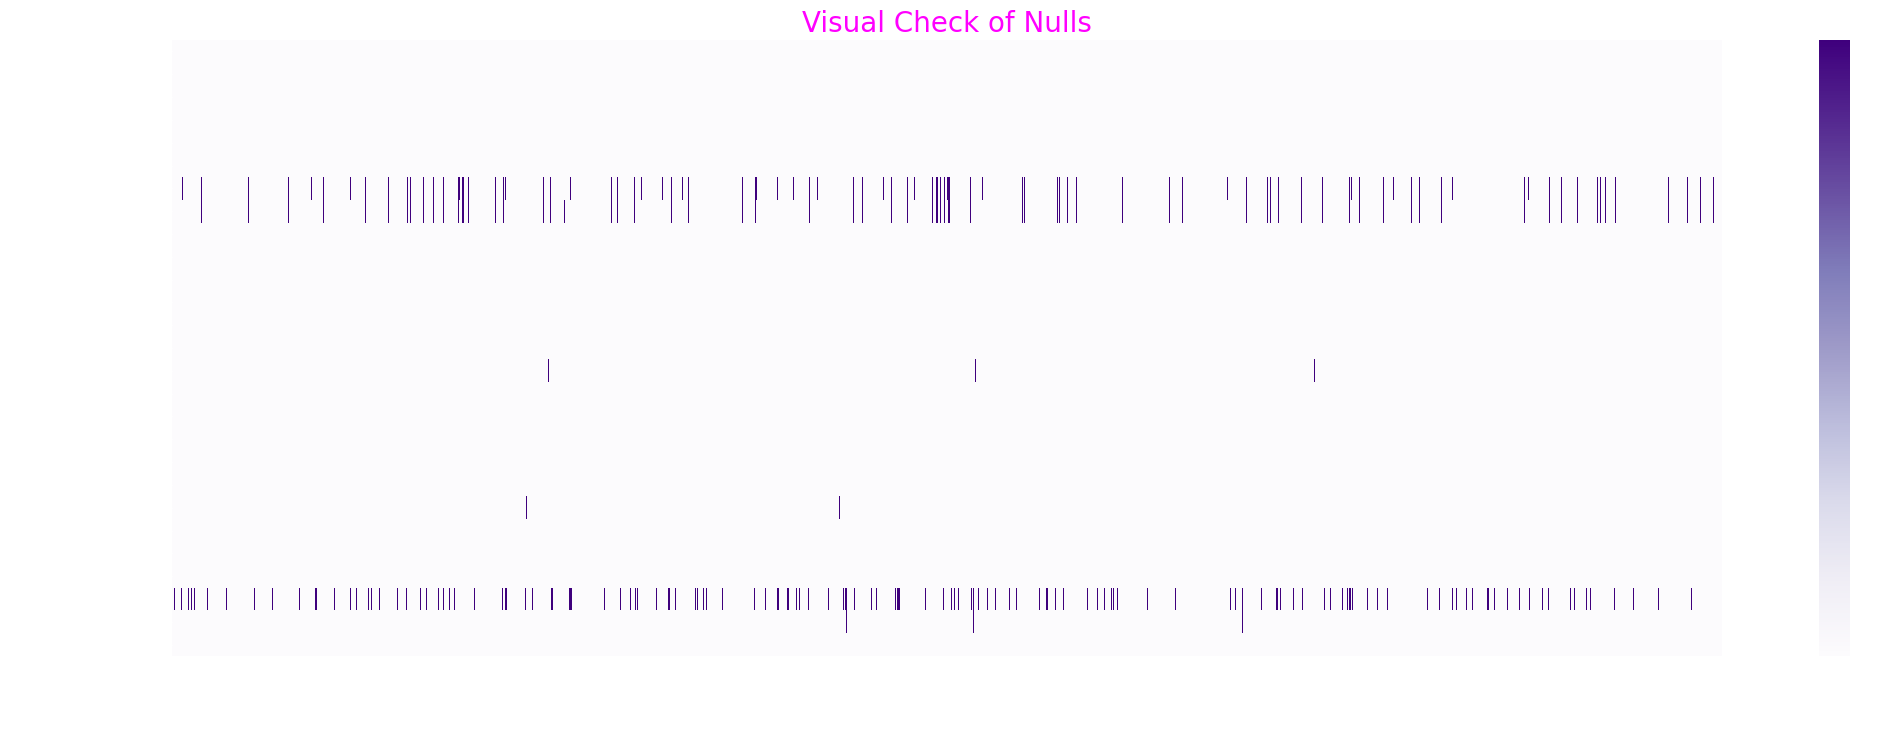

In [15]:
plt.figure(figsize=(25,8))
plt.style.use('dark_background')
sns.heatmap(df.isnull().T,cmap='Purples')
plt.title('Visual Check of Nulls',fontsize=20,color='magenta')
plt.show()

In [17]:
int(df.isna().sum().sum())
# since there are 81590 rows are null , we cant drop na ...

81590

In [18]:
#checking the unique values for columns
for _ in df.columns:
    print()
    print(f'Total Unique Values in {_} column are :- {df[_].nunique()}')
    print(f'Unique Values in {_} column are :-\n {df[_].unique()}')
    print(f'Value_counts of {_} column :-\n {df[_].value_counts()}')
    print()
    print('-'*120)


Total Unique Values in loan_amnt column are :- 1397
Unique Values in loan_amnt column are :-
 [10000.  8000. 15600. ... 36275. 36475.   725.]
Value_counts of loan_amnt column :-
 loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
           ...  
39200.0        1
38750.0        1
36275.0        1
36475.0        1
725.0          1
Name: count, Length: 1397, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in term column are :- 2
Unique Values in term column are :-
 [' 36 months' ' 60 months']
Value_counts of term column :-
 term
36 months    302005
60 months     94025
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in int_rate column are :- 566
Unique Values in int_rate column are :-
 [11.44 11.99 10.49  6.49 17.27 13.

**Null Treatment:**

In [19]:
df.loc[df['revol_util'].isna(),'revol_util'] = 0.0
df.loc[df['mort_acc'].isna(),'mort_acc'] = 0.0
df.loc[df['pub_rec_bankruptcies'].isna(),'pub_rec_bankruptcies'] = 0.0
df.loc[df['emp_title'].isna(),'emp_title'] = 'No Employee Title'
df.loc[df['title'].isna(),'title'] = 'Unavailable'
df['emp_length'] = df['emp_length'].fillna('< 1 year')

In [20]:
df.isna().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,0
emp_length,0
home_ownership,0
annual_inc,0


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,396030.0,53.754260,24.484857,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [22]:
df.describe(include='object').T

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,396030,173106,No Employee Title,22927
emp_length,396030,11,10+ years,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-2014,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


**Feature Engineering**

In [23]:

df['pub_rec'] = [1 if i > 1 else 0 for i in df['pub_rec']]
df['mort_acc'] = [1 if i > 1 else 0 for i in df['mort_acc']]
df['pub_rec_bankruptcies'] = [1 if i > 1 else 0 for i in df['pub_rec_bankruptcies']]

In [24]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
358005,8000.0,36 months,15.31,278.54,C,C2,MCPS,8 years,RENT,60000.0,Not Verified,Dec-2012,Fully Paid,debt_consolidation,Independent freedom,22.74,Jul-2002,7.0,0,13170.0,62.4,14.0,f,INDIVIDUAL,0,0,"682 Hawkins Divide\r\nNew Amy, OR 00813"


In [25]:
#Split issue_date into month and year
df[['issue_month', 'issue_year']] = df['issue_d'].str.split('-', expand=True)
df.drop(['issue_d'], axis=1, inplace=True)

In [26]:
#Split er_cr_line date into month and year
df[['er_cr_line_m', 'er_cr_line_y']] = df['earliest_cr_line'].str.split('-', expand=True)
df.drop(['earliest_cr_line'], axis=1, inplace=True)

In [27]:
df['address']

,address
0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,"679 Luna Roads\r\nGreggshire, VA 11650"
...,...
396025,"12951 Williams Crossing\r\nJohnnyville, DC 30723"
396026,"0114 Fowler Field Suite 028\r\nRachelborough, ..."
396027,"953 Matthew Points Suite 414\r\nReedfort, NY 7..."
396028,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL..."


In [28]:
#Split address into State and Zip code
import re
df[['state','zipcode']] = df['address'].str.extract(r'([A-Z]{2}) (\d{5})')
df.drop(['address'], axis=1, inplace=True)

In [29]:
df['state'].nunique(),df['zipcode'].nunique()

(54, 10)

In [30]:
df['state'].isna().sum(),df['zipcode'].isna().sum()

(np.int64(0), np.int64(0))

In [31]:
df['emp_length_yrs']=df['emp_length'].str.extract('(\d+)')
df.drop(['emp_length'],axis=1,inplace=True)

In [32]:
df['term']=df['term'].str.split().str[0].astype('object')

In [33]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
186013,22000.0,36,8.9,698.58,A,A5,nurse,RENT,74000.0,Verified,Fully Paid,credit_card,Credit card refinancing,22.29,8.0,0,19182.0,61.3,28.0,w,INDIVIDUAL,1,0,Feb,2014,Nov,2001,OR,05113,10


In [34]:
df.shape

(396030, 30)

In [39]:
#list of categorical columns
cat_cols = df.select_dtypes(include='object')
cat_cols.sample(3)

,term,grade,sub_grade,emp_title,home_ownership,verification_status,loan_status,purpose,title,initial_list_status,application_type,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
250649,60,C,C4,Supervisor,RENT,Verified,Charged Off,debt_consolidation,Cessna,f,INDIVIDUAL,Dec,2013,Oct,2006,DE,86630,3
382344,36,C,C4,Draftsman,MORTGAGE,Verified,Charged Off,debt_consolidation,Debt consolidation,f,INDIVIDUAL,Nov,2015,Jul,1999,WV,86630,5
164774,60,D,D4,Youth coirdinator,RENT,Source Verified,Charged Off,debt_consolidation,Debt consolidation,w,INDIVIDUAL,Nov,2014,Mar,1995,NJ,11650,10


In [40]:
#list of numerical columns
num_cols= df.select_dtypes(exclude='object')
num_cols.sample(3)

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
280541,7000.0,12.68,234.79,42000.0,21.80,4.0,0,1876.0,24.4,11.0,0,0
20443,30000.0,12.69,677.85,80000.0,20.06,13.0,0,50139.0,78.0,24.0,0,0
61493,25000.0,13.49,575.12,68000.0,21.16,12.0,0,22021.0,57.9,50.0,0,0


In [41]:
num_cols.skew()

,0
loan_amnt,0.777285
int_rate,0.420669
installment,0.983598
annual_inc,41.042725
dti,431.051225
open_acc,1.213019
pub_rec,6.812303
revol_bal,11.727515
revol_util,-0.074238
total_acc,0.864328


**Insights**
* Features are Right skewed

**Action**
* Need to apply log transformations in order to normalise them

In [42]:
df1=df.copy()
df1.sample(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
239859,21000.0,36,12.12,698.71,B,B3,3DMX INC,RENT,98000.0,Source Verified,Fully Paid,debt_consolidation,Organizing my finances,13.84,7.0,0,18171.0,56.7,13.0,f,INDIVIDUAL,0,0,May,2012,Oct,2004,IA,05113,7
26483,9000.0,36,12.12,299.45,B,B3,Industry Rag,RENT,50000.0,Verified,Fully Paid,small_business,Small Business,5.88,5.0,0,4777.0,79.6,11.0,f,INDIVIDUAL,0,0,Jun,2012,Nov,1995,AP,30723,1
28145,3675.0,36,10.16,118.86,B,B1,Groton Board of Education,MORTGAGE,52000.0,Verified,Fully Paid,credit_card,Credit card refinancing,25.77,13.0,0,25039.0,68.8,24.0,f,INDIVIDUAL,1,0,Oct,2012,May,1992,IA,30723,10


# Q1. What percentage of customers have fully paid their Loan Amount?

In [43]:
df['loan_status'].value_counts(normalize=True)*100

,proportion
loan_status,
Fully Paid,80.387092
Charged Off,19.612908


**Insights**:
* Target variable distribution is 80%-20%. Data is significantly imbalanced

In [44]:
cp = ['indigo','m','darkviolet','magenta','mediumorchid','violet','purple','orchid','mediumpurple','deeppink','blueviolet','darkmagenta','fuchsia']

In [45]:
num_cols.iloc[:,[0,2,3,4,5,6,8,9,10]].sample()

,loan_amnt,installment,annual_inc,dti,open_acc,pub_rec,revol_util,total_acc,mort_acc
124790,3800.0,76.84,36000.0,23.83,10.0,0,22.8,19.0,0


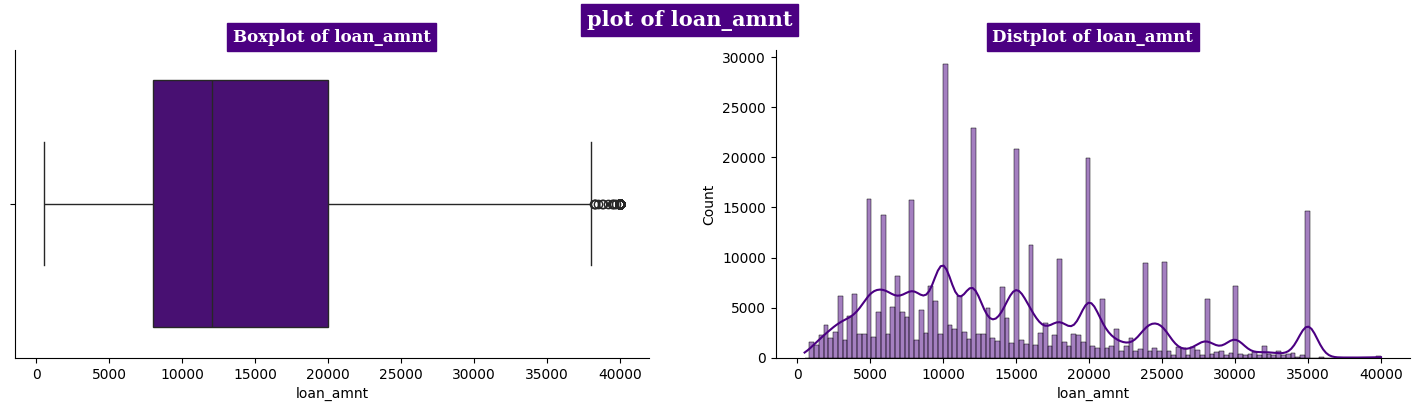

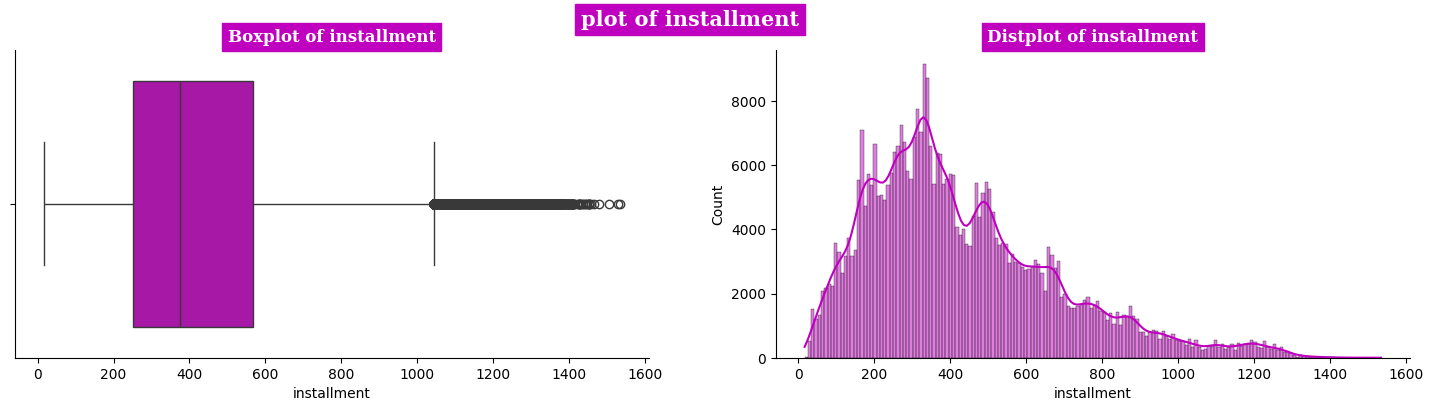

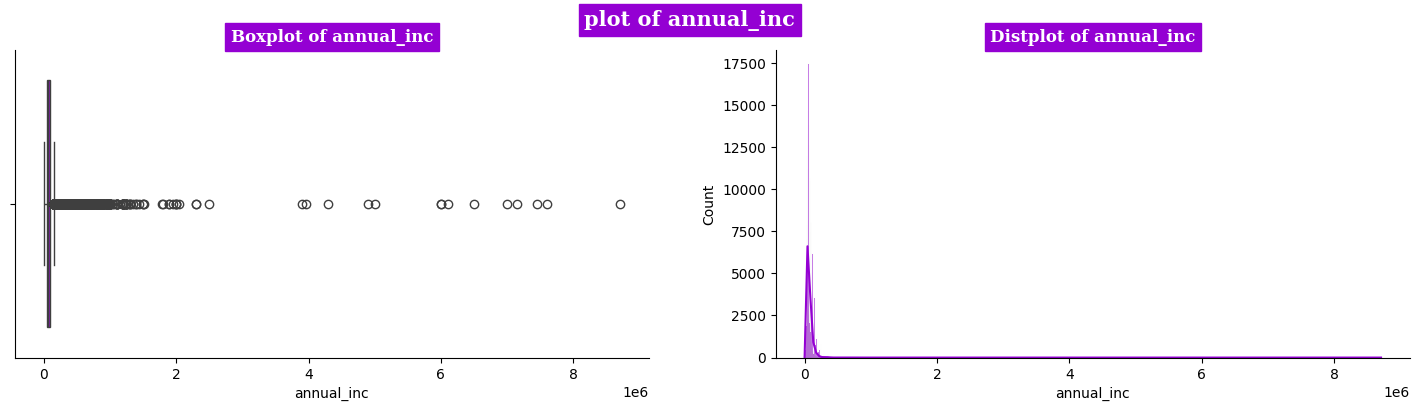

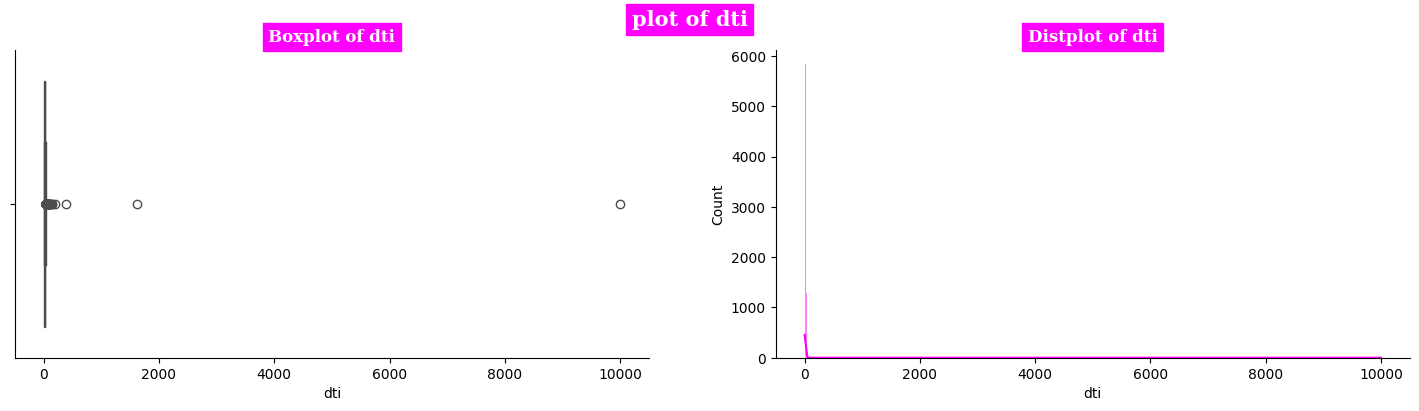

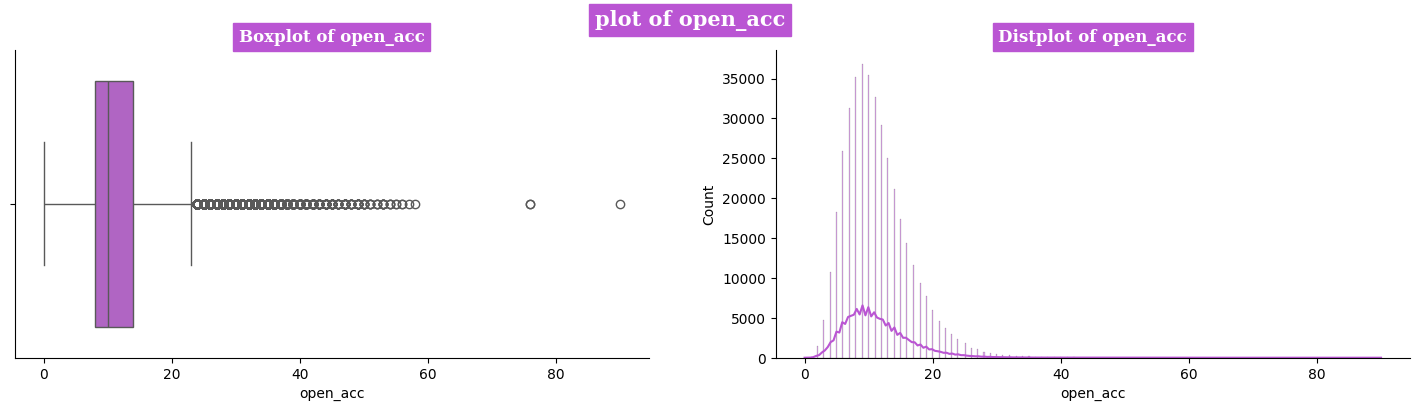

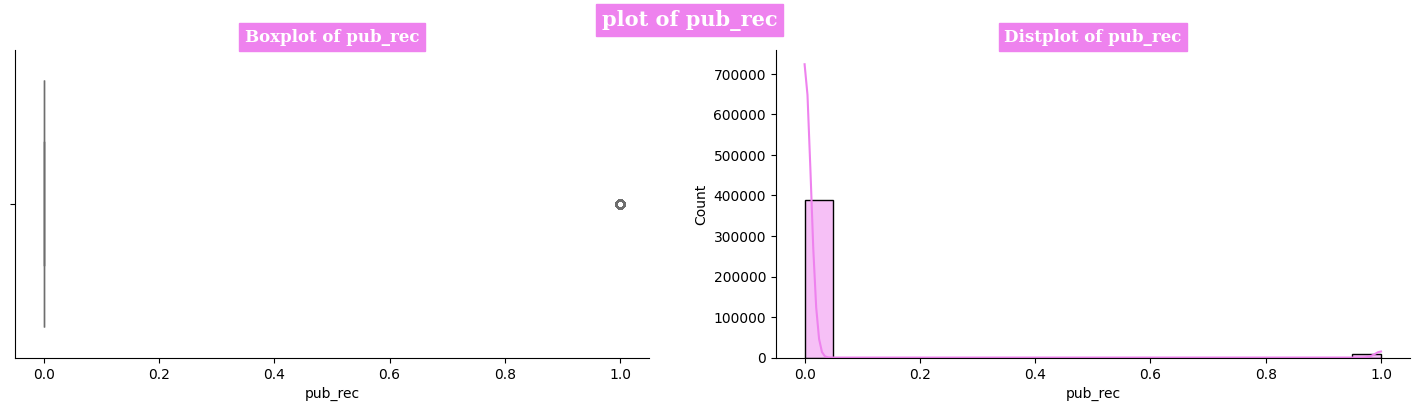

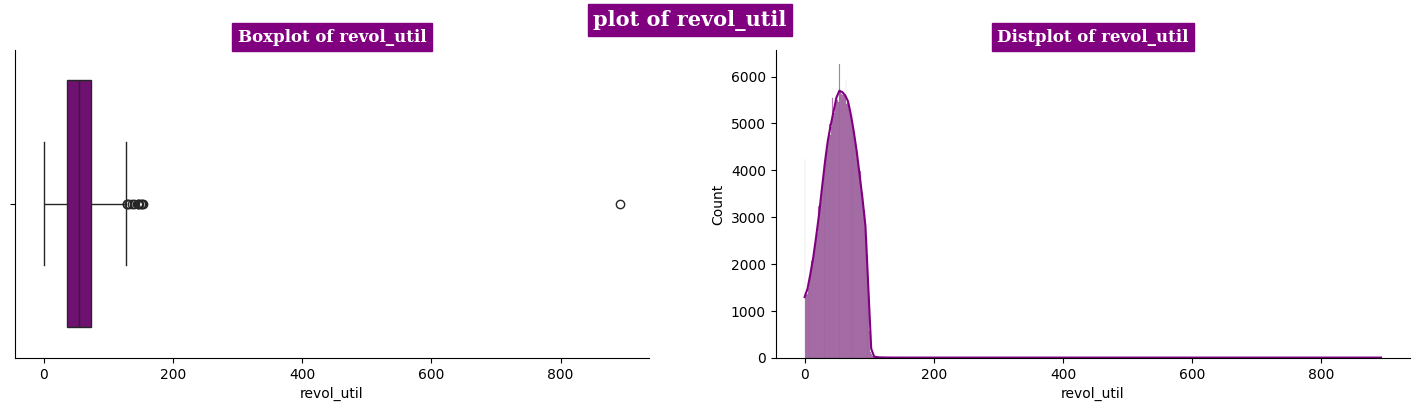

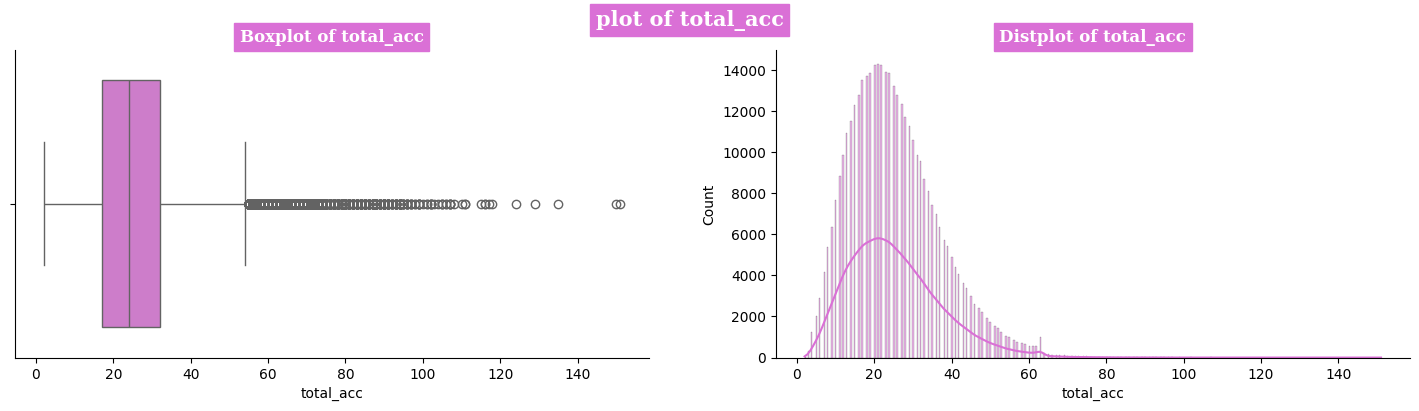

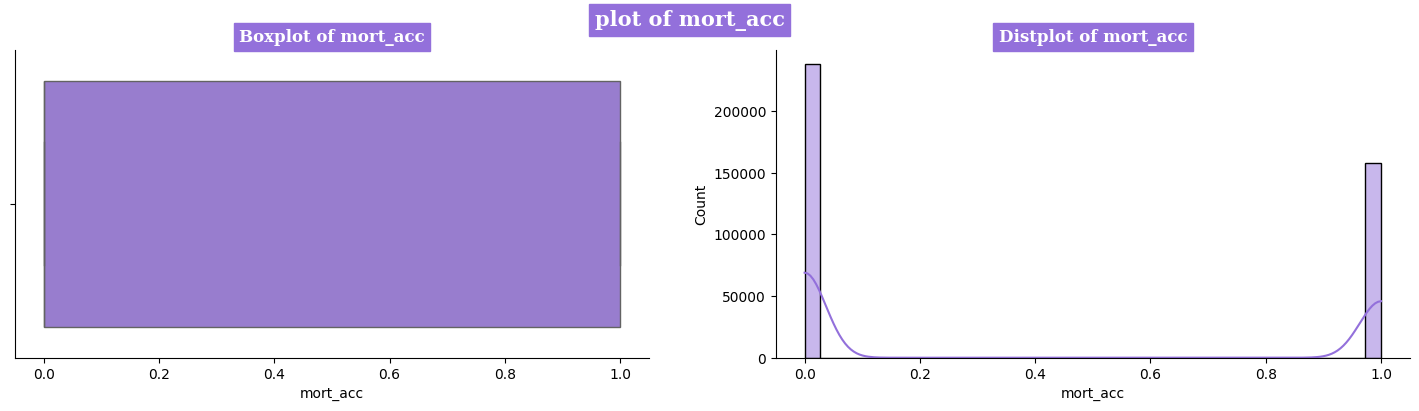

In [46]:
plt.style.use('default')
plt.style.use('seaborn-v0_8-bright')
outlier_graphical_cols = num_cols.iloc[:,[0,2,3,4,5,6,8,9,10]]
for _,col in enumerate(outlier_graphical_cols.columns):
    plt.figure(figsize=(18,4))
    plt.suptitle(f'plot of {col}',fontsize=15,fontfamily='serif',fontweight='bold',backgroundcolor=cp[_],color='w')
    plt.subplot(121)
    sns.boxplot(x=df[col],color=cp[_])
    plt.title(f'Boxplot of {col}',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[_],color='w')
    plt.subplot(122)
    sns.histplot(x=df[col], kde=True,color=cp[_])
    plt.title(f'Distplot of {col}',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[_],color='w')
    sns.despine()
    plt.show()

In [47]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


**Insights**:
* The analysis suggests a prevalence of outliers, prompting further investigation into outlier detection techniques.
* Among the numerical features, Potential outliers may still be present.
* Notably, features such as Pub_rec, Mort_acc, and Pub_rec_bankruptcies display a sparse distribution of unique values, indicating the potential benefit of generating binary features from these variables.

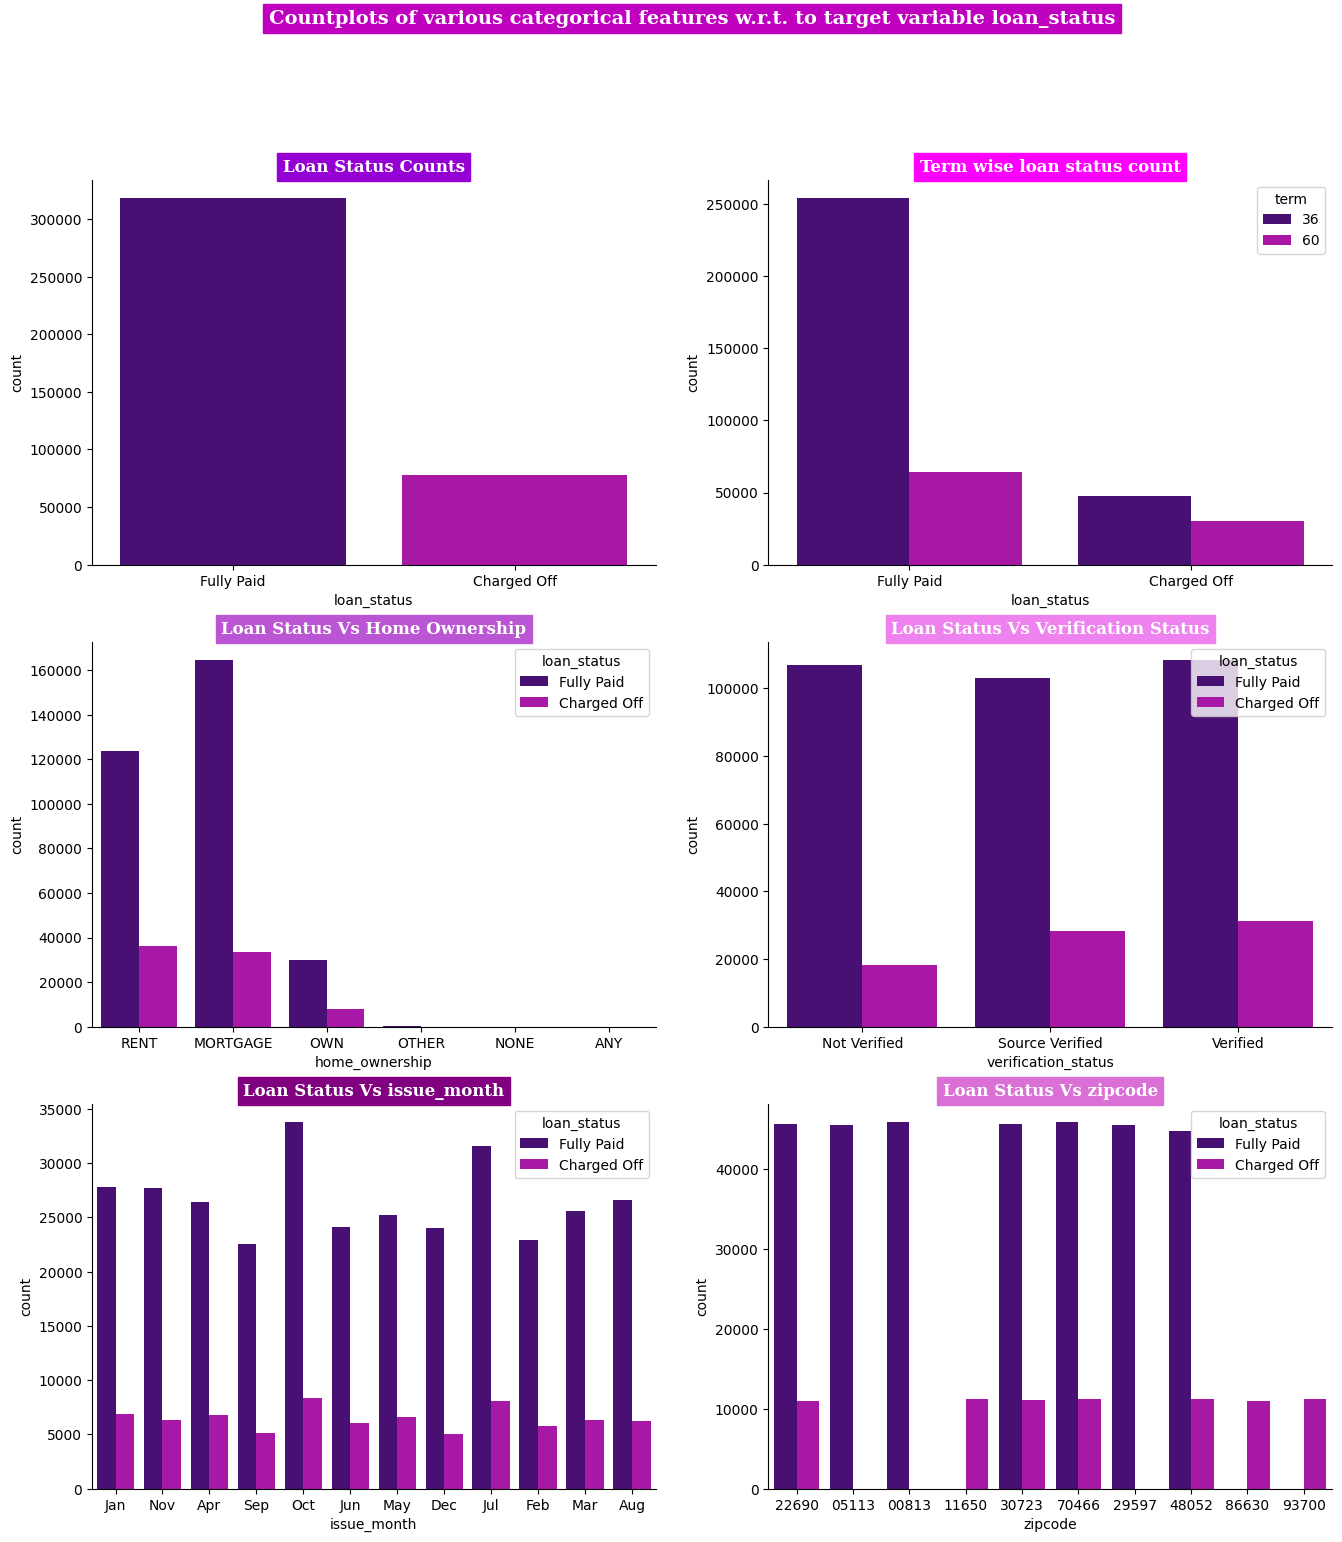

In [48]:
#Countplots of various categorical features w.r.t. to target variable loan_status
plt.figure(figsize=(16,17))
plt.suptitle('Countplots of various categorical features w.r.t. to target variable loan_status',
             fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor=cp[1],color='w')
plt.subplot(321)
sns.countplot(data=df, x='loan_status',palette=cp)
plt.title('Loan Status Counts',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[2],color='w')
plt.subplot(322)
sns.countplot(data=df, x='loan_status', hue='term',palette=cp)
plt.title('Term wise loan status count',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[3],color='w')
plt.subplot(323)
sns.countplot(data=df, x='home_ownership', hue='loan_status',palette=cp)
plt.title('Loan Status Vs Home Ownership',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[4],color='w')
plt.subplot(324)
sns.countplot(data=df, x='verification_status', hue='loan_status',palette=cp)
plt.title('Loan Status Vs Verification Status',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[5],color='w')
plt.subplot(325)
sns.countplot(data=df, x='issue_month', hue='loan_status',palette=cp)
plt.title('Loan Status Vs issue_month',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[6],color='w')
plt.subplot(326)
sns.countplot(data=df, x='zipcode', hue='loan_status',palette=cp)
plt.title('Loan Status Vs zipcode',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[7],color='w')
sns.despine()
plt.show()

In [49]:
zip_codes = ["11650", "86630", "93700"]
states = df[df['zipcode'].isin(zip_codes)]['state']

for zip_code, state in zip(zip_codes, states):
    print(f"Zip code: {zip_code}, State: {state}")

Zip code: 11650, State: VA
Zip code: 86630, State: MI
Zip code: 93700, State: MD


**Observations**:
* It's been observed that loans haven't been completely repaid in zip codes 11650, 86630, and 93700.
* Loans haven't been repaid by borrowers residing in 'VA', 'MI', and 'MD'.

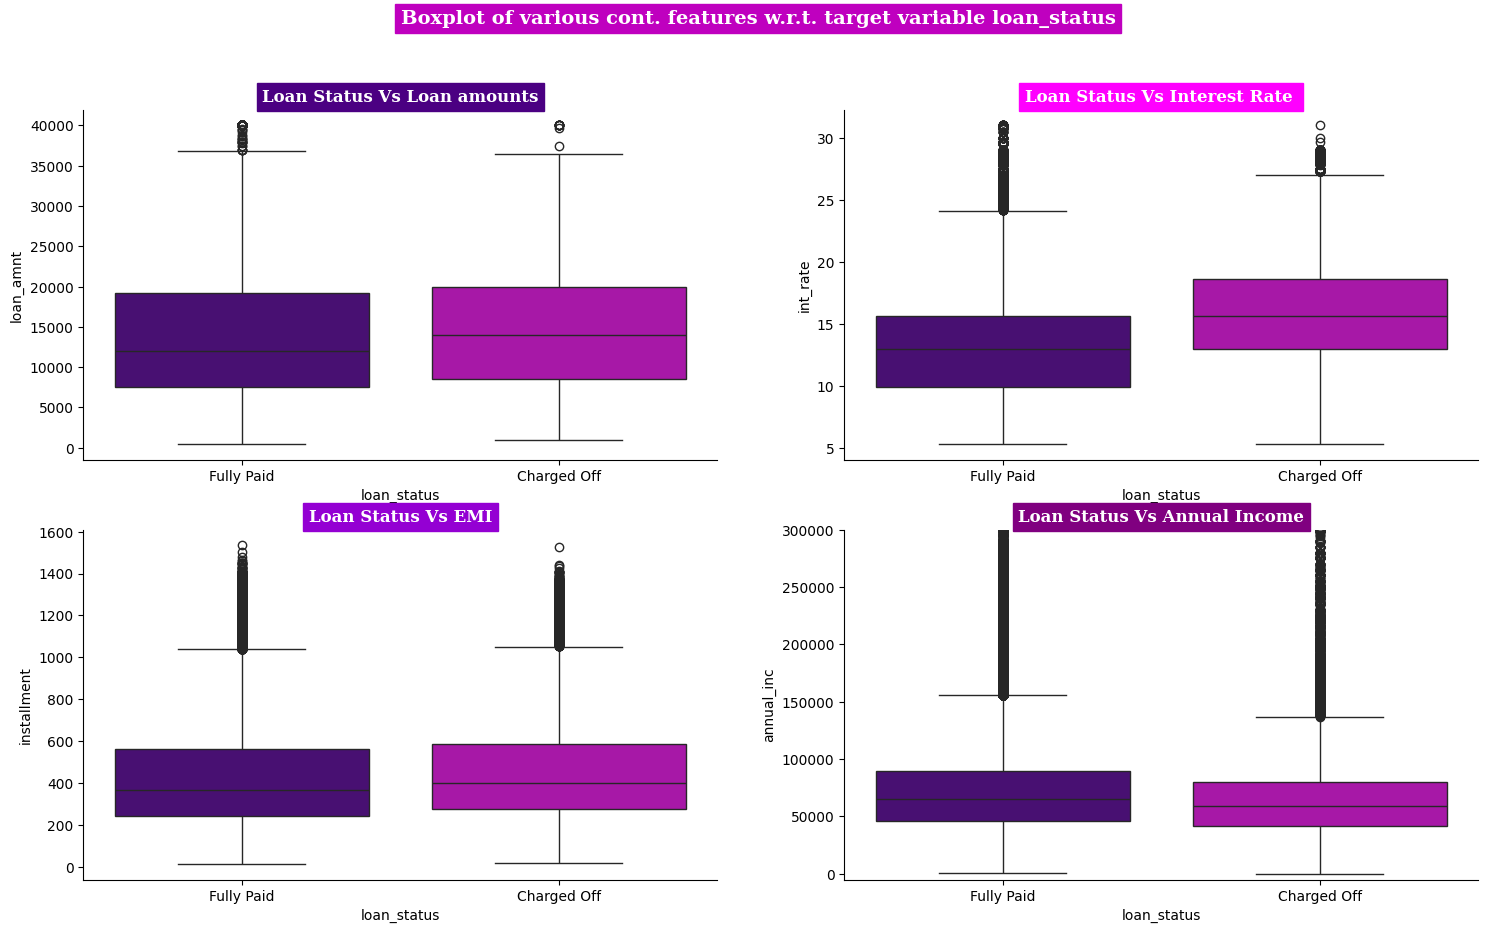

In [50]:
#Boxplot of various cont. features w.r.t. target variable loan_status
plt.figure(figsize=(18,10))
plt.suptitle('Boxplot of various cont. features w.r.t. target variable loan_status',
             fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor=cp[1],color='w')
plt.subplot(221)
sns.boxplot(data=df, x='loan_status', y='loan_amnt',palette=cp)
plt.title('Loan Status Vs Loan amounts',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[0],color='w')
plt.subplot(222)
sns.boxplot(data=df, x='loan_status', y='int_rate',palette=cp)
plt.title('Loan Status Vs Interest Rate ',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[3],color='w')
plt.subplot(223)
sns.boxplot(data=df, x='loan_status', y='installment',palette=cp)
plt.title('Loan Status Vs EMI',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[2],color='w')
plt.subplot(224)
sns.boxplot(data=df, x='loan_status', y='annual_inc',palette=cp)
plt.ylim(bottom=-5000, top=300000)
plt.title('Loan Status Vs Annual Income',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[6],color='w')
sns.despine()
plt.show()

**Observations**:
* Charged Off customers exhibit a notably higher median interest rate compared to Fully Paid customers.
* The median annual income of Charged Off customers is lower than that of Fully Paid customers.
* Charged Off customers tend to have a higher median EMI compared to Fully Paid customers.
* The median loan amount for Charged Off customers surpasses that of Fully Paid customers.

In [52]:
df.sample(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
208373,20000.0,36,12.39,668.02,C,C1,Purchasing Manager,MORTGAGE,95000.0,Verified,Fully Paid,credit_card,Credit card refinancing,29.67,18.0,0,37862.0,81.4,20.0,f,INDIVIDUAL,0,0,Jan,2015,Jul,2001,OH,70466,3
226991,20000.0,36,7.62,623.23,A,A3,Epic Healthcare,MORTGAGE,80000.0,Source Verified,Fully Paid,credit_card,Credit card refinancing,16.05,15.0,0,27679.0,62.5,29.0,f,INDIVIDUAL,1,0,Aug,2013,Dec,1998,OK,29597,3
56812,23000.0,60,10.99,499.97,B,B2,Parter,RENT,150000.0,Verified,Fully Paid,debt_consolidation,Debt consolidation,11.30,10.0,0,1857.0,4.1,28.0,w,INDIVIDUAL,0,0,May,2014,Jul,1973,FL,70466,5


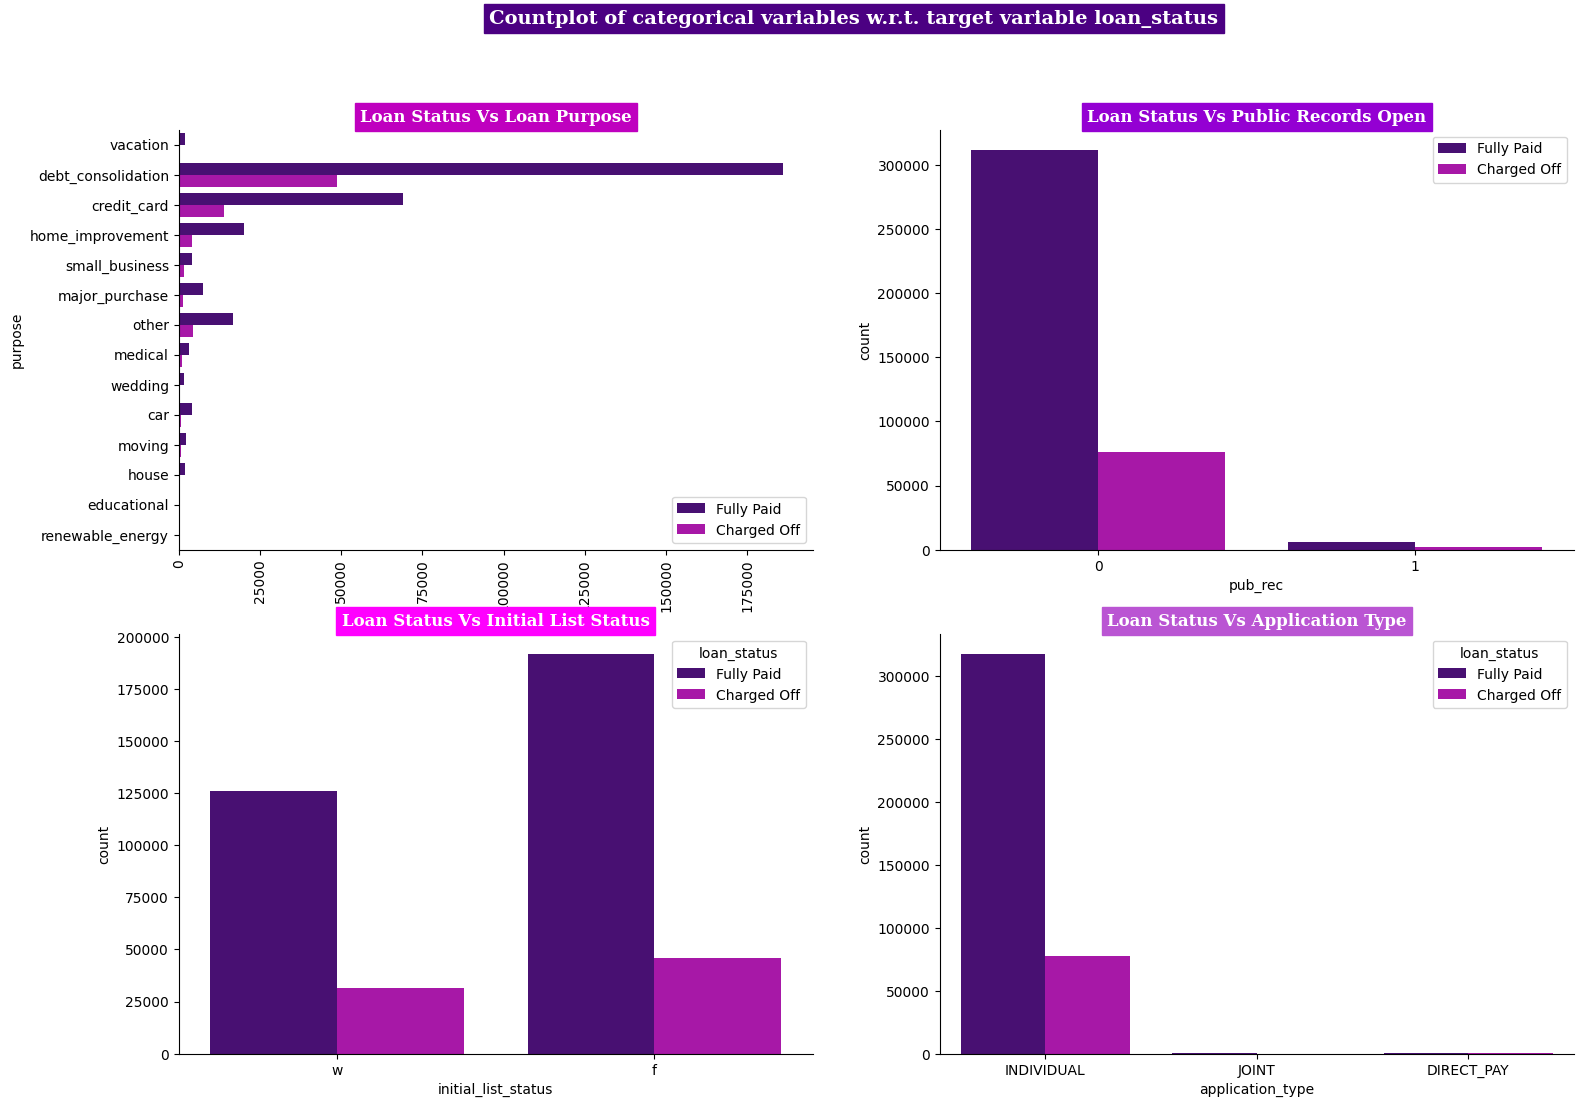

In [53]:
#Countplot of categorical variables w.r.t. target variable loan_status
plt.figure(figsize=(18,12))
plt.suptitle('Countplot of categorical variables w.r.t. target variable loan_status',
             fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor=cp[0],color='w')
plt.subplot(221)
sns.countplot(data=df, y='purpose', hue='loan_status',palette=cp)
plt.xticks(rotation=90)
plt.title('Loan Status Vs Loan Purpose',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[1],color='w')
plt.legend(loc=4)
plt.subplot(222)
sns.countplot(data=df, x='pub_rec',hue='loan_status',palette=cp)
plt.title('Loan Status Vs Public Records Open',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[2],color='w')
plt.legend(loc=1)
plt.subplot(223)
sns.countplot(data=df, x='initial_list_status', hue='loan_status',palette=cp)
plt.title('Loan Status Vs Initial List Status',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[3],color='w')
plt.subplot(224)
sns.countplot(data=df, x='application_type',hue='loan_status',palette=cp)
plt.title('Loan Status Vs Application Type',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[4],color='w')
sns.despine()
plt.show()

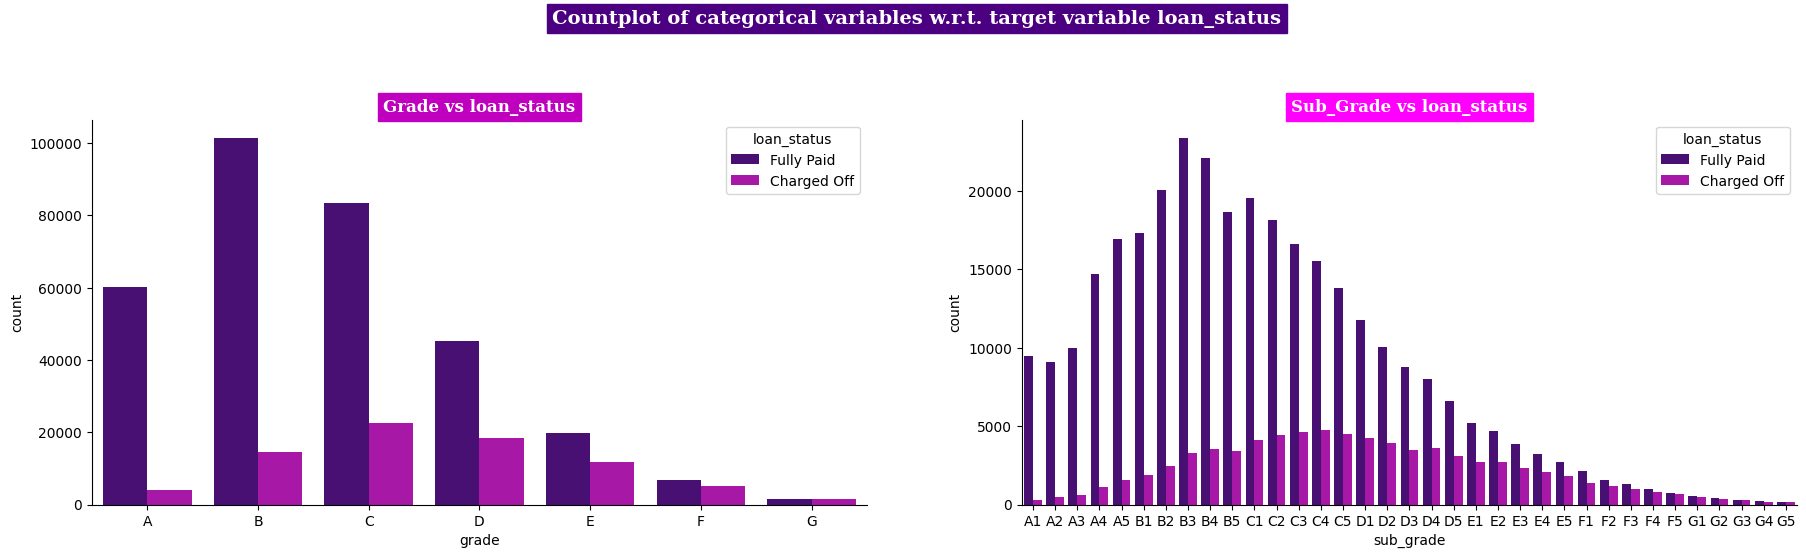

In [54]:
plt.figure(figsize=(22,11))
plt.suptitle('Countplot of categorical variables w.r.t. target variable loan_status',
             fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor=cp[0],color='w')
plt.subplot(221)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade,palette=cp)
plt.title('Grade vs loan_status',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[1],color='w')
plt.subplot(222)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade,palette=cp)
plt.title('Sub_Grade vs loan_status',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[3],color='w')
sns.despine()
plt.show()

**Observations**:
* Top 2 loan purpose categories are Debit Consolidation and Credit Card
* Topmost loan type application is INDIVIDUAL
* The distribution of open_acc appears to be relatively normal when visualized graphically.
* Charged Off and Fully Paid categories exhibit similar distributions.

In [55]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
369697,35000.0,60,25.89,1045.64,G,G3,Grossman Companies,MORTGAGE,150000.0,Source Verified,Fully Paid,debt_consolidation,Debt consolidation,8.58,6.0,0,118152.0,81.0,13.0,f,INDIVIDUAL,1,0,Sep,2013,Nov,1994,AE,00813,1


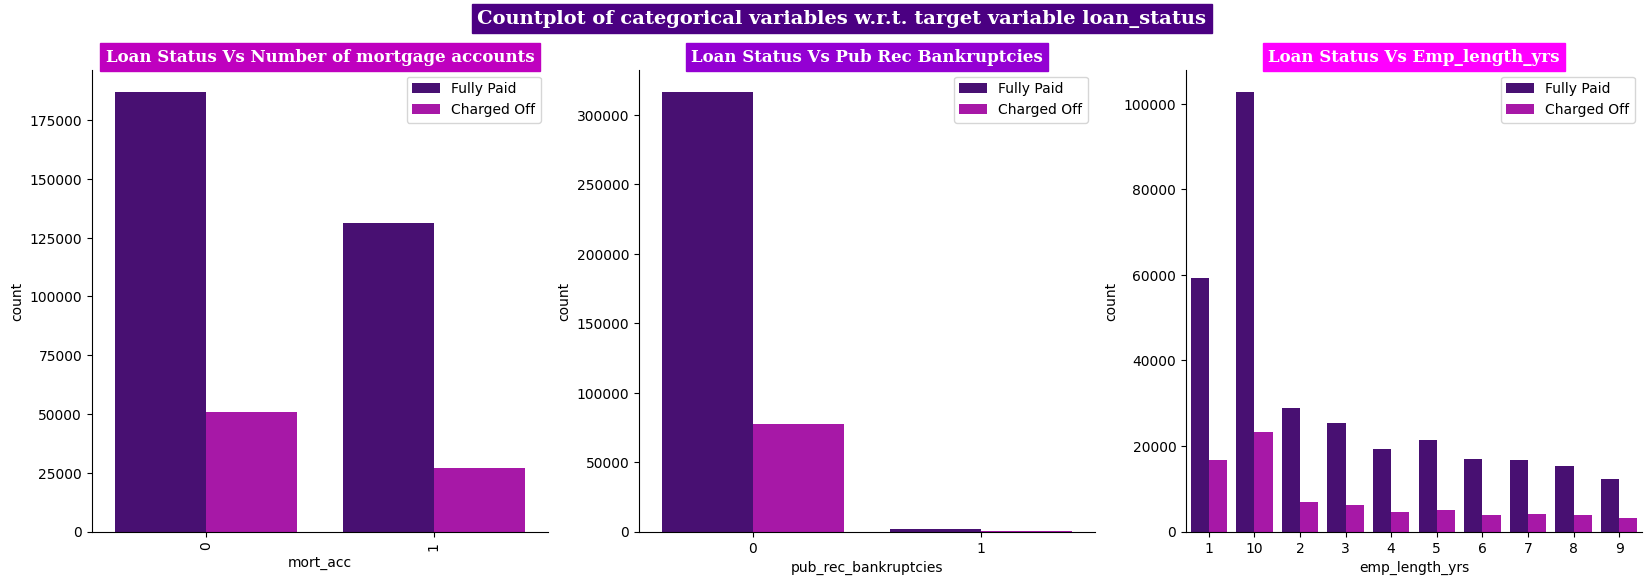

In [56]:
#Countplot for various categorical features w.r.t. target variable loan_status

plt.figure(figsize=(20,6))
plt.suptitle('Countplot of categorical variables w.r.t. target variable loan_status',
             fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor=cp[0],color='w')
plt.subplot(131)
sns.countplot(data=df, x='mort_acc',hue='loan_status',palette=cp)
plt.xticks(rotation=90)
plt.title('Loan Status Vs Number of mortgage accounts',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[1],color='w')
plt.legend(loc=1)
plt.subplot(132)
sns.countplot(data=df, x='pub_rec_bankruptcies',hue='loan_status',palette=cp)
plt.title('Loan Status Vs Pub Rec Bankruptcies',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[2],color='w')
plt.legend(loc=1)
plt.subplot(133)
order = sorted(df.emp_length_yrs.unique().tolist())
sns.countplot(data=df, x='emp_length_yrs',hue='loan_status',order=order,palette=cp)
plt.title('Loan Status Vs Emp_length_yrs',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[3],color='w')
plt.legend(loc=1)
sns.despine()
plt.show()

# Q2. Comment about the correlation between Loan Amount and Installment features.

In [57]:
df[['loan_amnt','installment']].corr()

,loan_amnt,installment
loan_amnt,1.000000,0.953929
installment,0.953929,1.000000


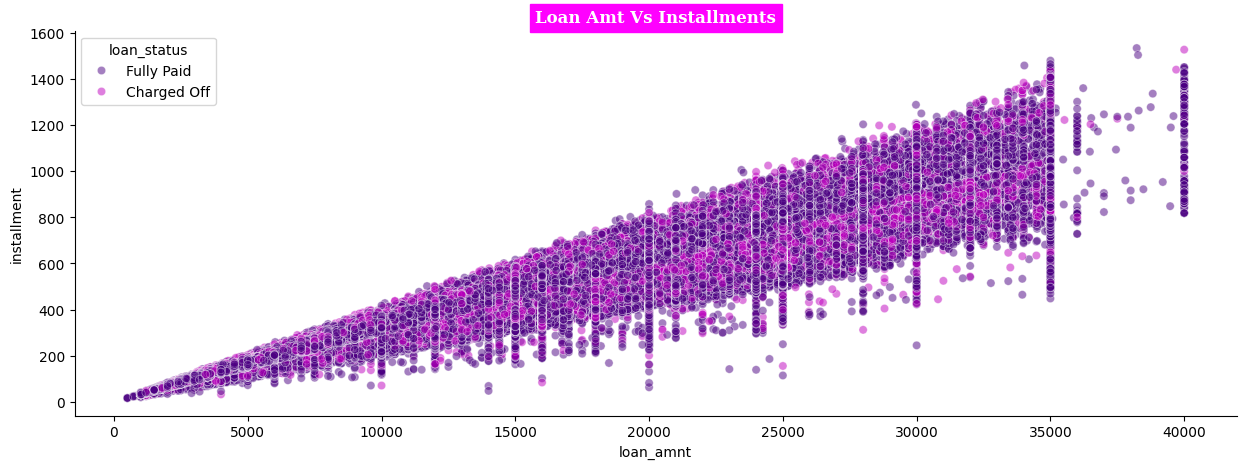

In [58]:
plt.figure(figsize = (15,5))
sns.scatterplot(data = df, x = 'loan_amnt', y = 'installment', alpha = 0.5, hue = 'loan_status', palette = cp)
plt.title('Loan Amt Vs Installments',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[3],color='w')
sns.despine()
plt.show()

Insights:
The correlation coefficient measures the strength and direction of the linear relationship between two variables. In this case, the correlation coefficient between 'loan_amnt' and 'installment' is quite high, approximately 0.95, indicating a strong positive linear relationship between these two variables.

* Loan Terms: Understanding the relationship between loan amount and installment payments is crucial for setting appropriate loan terms. Lenders can adjust loan terms such as interest rates and repayment periods based on the borrower's ability to handle installment payments associated with different loan amounts.

* Potential Multicollinearity: When building predictive models, it's essential to be cautious of multicollinearity between highly correlated predictor variables. Multicollinearity can lead to unstable estimates and difficulties in interpreting the model coefficients. Therefore, it might be necessary to address multicollinearity through techniques such as variable selection or

# Q3. The majority of people have home ownership as

In [59]:
(df['home_ownership'].value_counts(normalize=True)*100).to_frame()

,proportion
home_ownership,
MORTGAGE,50.084085
RENT,40.347953
OWN,9.531096
OTHER,0.028281
NONE,0.007828
ANY,0.000758


**Insights**:
* **Mortgage** holders comprise the majority with approximately **50.08%**, indicating that a significant portion of individuals own homes through Mortgage agreements.
* **Renters** constitute a substantial portion, accounting for around **40.35%** of home ownership types. This suggests a sizable demographic of individuals who opt for renting rather than owning a home.

# Q4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

In [62]:
pd.crosstab(df['grade'],df['loan_status'],normalize='index').T

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,0.062879,0.12573,0.211809,0.288678,0.373634,0.42788,0.478389
Fully Paid,0.937121,0.87427,0.788191,0.711322,0.626366,0.57212,0.521611


**Insights**:
True. **Grade 'A' borrowers demonstrate a significantly high likelihood  
of fully repaying their loans, with approximately 93.71% of loans being fully paid **. This suggests that borrowers with the highest credit rating are more inclined to fulfill their loan obligations successfully.

* The proportion of charged-off loans for grade 'A' borrowers is relatively low, standing at approximately 6.29%. This indicates a low default rate among borrowers with the highest credit rating, emphasizing their creditworthiness and reliability in loan repayment.

# Q5. Name the top 2 afforded job titles.

In [64]:
df[df['emp_title']!='No Employee Title']['emp_title'].value_counts().to_frame().head()

,count
emp_title,
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830


In [66]:
df.groupby('emp_title')['loan_status'].count().sort_values(ascending=False)[1:6]

,loan_status
emp_title,
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830


**Insights**:

* The Most afforded job titles are Teachers & Managers

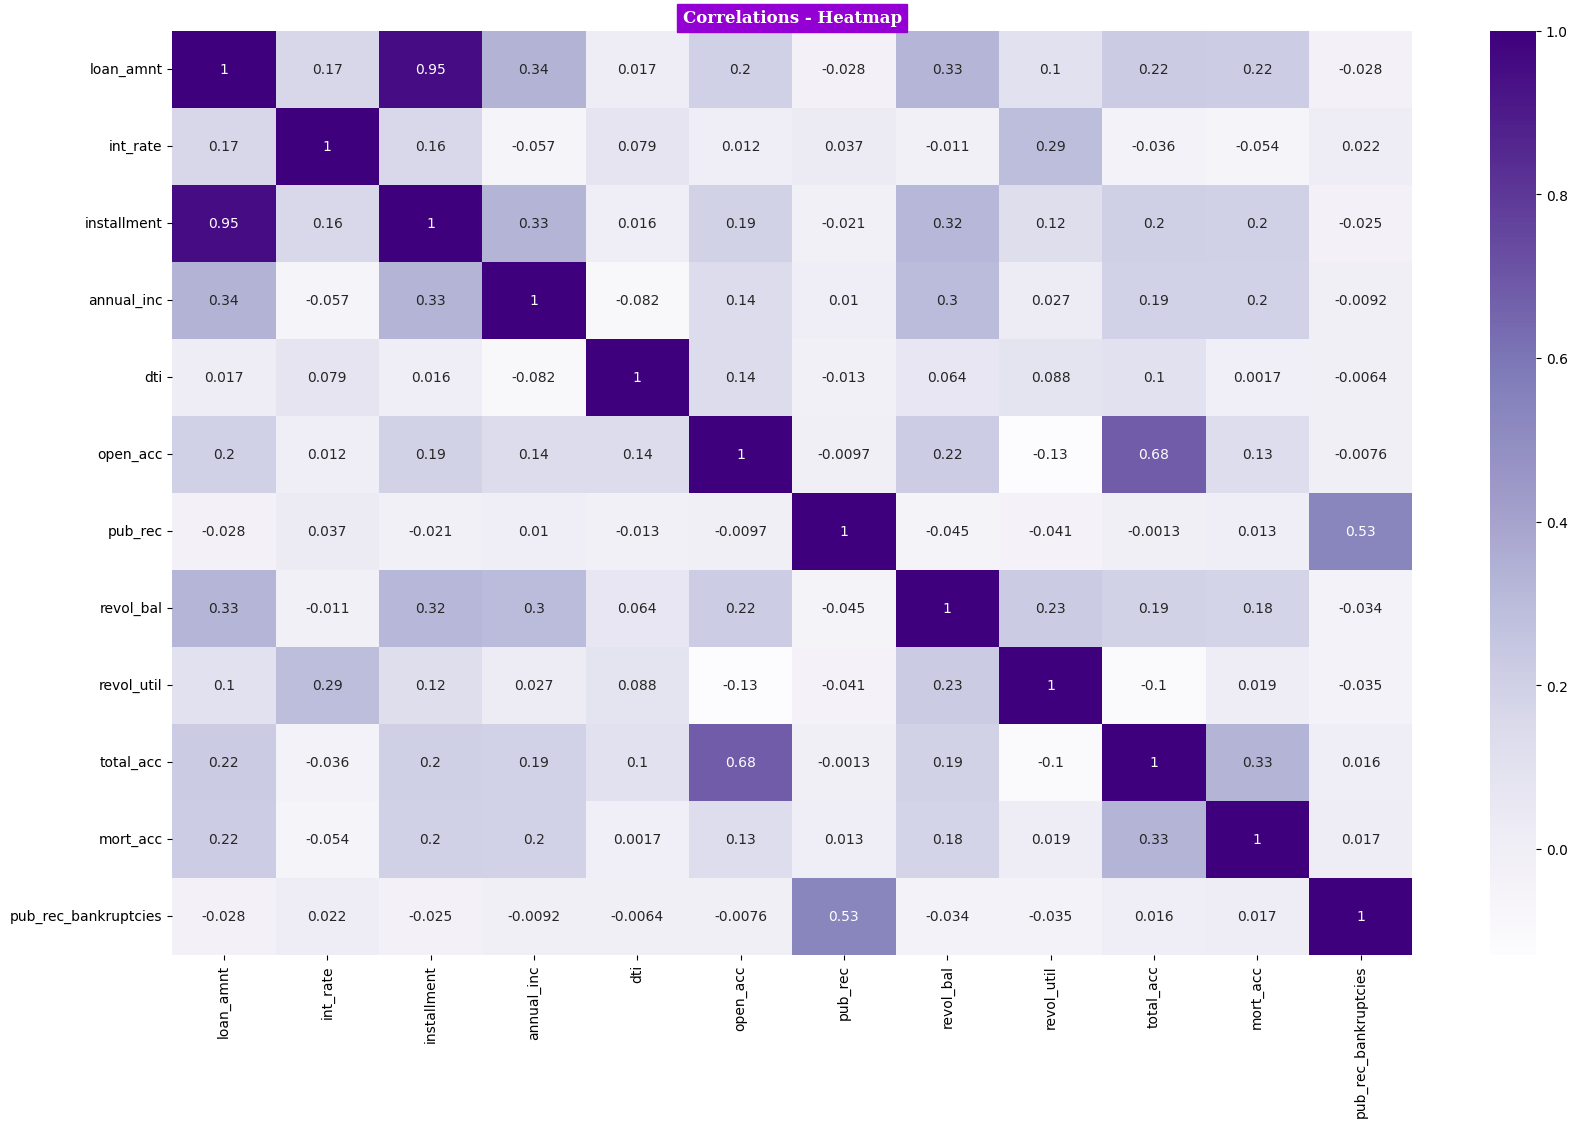

In [67]:
plt.figure(figsize=(20,12))
sns.heatmap(num_cols.corr(), annot=True, cmap='Purples')
plt.title('Correlations - Heatmap',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[2],color='w')
plt.show()

**Observations**:
* There exists a strong correlation between loan_amnt and installment, indicating that higher loan amounts correspond to larger installment payments.
* The variables total_acc and open_acc exhibit a significant correlation.
* There is a notable correlation between pub_rec_bankruptcies and pub_rec.

**Outlier Treatment:**

In [68]:
numerical_cols = df.select_dtypes(include=np.number).columns
numerical_cols

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [69]:
# outlier treatment
def remove_outliers_zscore(df, threshold=2): #(considering 2 std.dev away from mean approx 95% of data)
    """
    Remove outliers from a DataFrame using the Z-score method.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The Z-score threshold for identifying outliers.
                           Observations with a Z-score greater than this threshold
                           will be considered as outliers.

    Returns:
        DataFrame: The DataFrame with outliers removed.
    """
    # Calculate Z-scores for numerical columns
    z_scores = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()

    # Identify outliers
    outliers = np.abs(z_scores) > threshold

    # Keep non-outliers for numerical columns
    df_cleaned = df[~outliers.any(axis=1)]

    return df_cleaned

cleaned_df = remove_outliers_zscore(df1)
print(cleaned_df.shape)

(311392, 30)


In [70]:
def clip_outliers_zscore(df, threshold=2):
    """
    Clip outliers in a DataFrame using the Z-score method.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The Z-score threshold for identifying outliers.
                           Observations with a Z-score greater than this threshold
                           will be considered as outliers.

    Returns:
        DataFrame: The DataFrame with outliers clipped.
    """
    # Calculate Z-scores for numerical columns
    z_scores = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()

    # Clip outliers
    clipped_values = df[numerical_cols].clip(df[numerical_cols].mean() - threshold * df[numerical_cols].std(),
                                             df[numerical_cols].mean() + threshold * df[numerical_cols].std(),
                                             axis=1)

    # Assign clipped values to original DataFrame
    df_clipped = df.copy()
    df_clipped[numerical_cols] = clipped_values

    return df_clipped

clipped_df = clip_outliers_zscore(df1)
print(clipped_df.shape)

(396030, 30)


In [71]:
data = cleaned_df.copy()
cp_data = clipped_df.copy()
data.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
320007,9600.0,36,19.05,352.15,D,D4,Zelman & Associates,MORTGAGE,78000.0,Source Verified,Fully Paid,wedding,Wedding Loan,9.48,6.0,0,6555.0,68.3,6.0,f,INDIVIDUAL,0,0,Mar,2013,Jan,2008,KY,70466,1


In [72]:
data['pub_rec_bankruptcies'].value_counts() , data['pub_rec'].value_counts()

(pub_rec_bankruptcies
 0    311392
 Name: count, dtype: int64,
 pub_rec
 0    311392
 Name: count, dtype: int64)

In [73]:
cp_data['pub_rec_bankruptcies'].value_counts() , cp_data['pub_rec'].value_counts()

(pub_rec_bankruptcies
 0.000000    393705
 0.158662      2325
 Name: count, dtype: int64,
 pub_rec
 0.000000    388011
 0.301947      8019
 Name: count, dtype: int64)

In [74]:
data.shape

(311392, 30)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311392 entries, 0 to 396029
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             311392 non-null  float64
 1   term                  311392 non-null  object 
 2   int_rate              311392 non-null  float64
 3   installment           311392 non-null  float64
 4   grade                 311392 non-null  object 
 5   sub_grade             311392 non-null  object 
 6   emp_title             311392 non-null  object 
 7   home_ownership        311392 non-null  object 
 8   annual_inc            311392 non-null  float64
 9   verification_status   311392 non-null  object 
 10  loan_status           311392 non-null  object 
 11  purpose               311392 non-null  object 
 12  title                 311392 non-null  object 
 13  dti                   311392 non-null  float64
 14  open_acc              311392 non-null  float64
 15  pub_r

 **Manual encoding**

In [77]:
data['loan_status']=data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

data['initial_list_status']=data.initial_list_status.map({'w':0, 'f':1})

In [78]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
0,10000.0,36,11.44,329.48,B,B4,Marketing,RENT,117000.0,Not Verified,1,vacation,Vacation,26.24,16.0,0,36369.0,41.8,25.0,0,INDIVIDUAL,0,0,Jan,2015,Jun,1990,OK,22690,10
1,8000.0,36,11.99,265.68,B,B5,Credit analyst,MORTGAGE,65000.0,Not Verified,1,debt_consolidation,Debt consolidation,22.05,17.0,0,20131.0,53.3,27.0,1,INDIVIDUAL,1,0,Jan,2015,Jul,2004,SD,05113,4
2,15600.0,36,10.49,506.97,B,B3,Statistician,RENT,43057.0,Source Verified,1,credit_card,Credit card refinancing,12.79,13.0,0,11987.0,92.2,26.0,1,INDIVIDUAL,0,0,Jan,2015,Aug,2007,WV,05113,1
3,7200.0,36,6.49,220.65,A,A2,Client Advocate,RENT,54000.0,Not Verified,1,credit_card,Credit card refinancing,2.60,6.0,0,5472.0,21.5,13.0,1,INDIVIDUAL,0,0,Nov,2014,Sep,2006,MA,00813,6
4,24375.0,60,17.27,609.33,C,C5,Destiny Management Inc.,MORTGAGE,55000.0,Verified,0,credit_card,Credit Card Refinance,33.95,13.0,0,24584.0,69.8,43.0,1,INDIVIDUAL,0,0,Apr,2013,Mar,1999,VA,11650,9


**Feature selection - done by hypothesis testing & VIF(multicolinearity)**

     Find VIF after modelling and remove features with high VIF (>5):

In [79]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

In [80]:

cat_cols = data.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(data[col], data['loan_status']))
    if p > 0.05:
        print('>>>>>>> Independent feature - Not Significant:',col,' >> p value:',p)

>>>>>>> Independent feature - Not Significant: emp_title  >> p value: 0.5367121560200798
>>>>>>> Independent feature - Not Significant: title  >> p value: 1.0
>>>>>>> Independent feature - Not Significant: er_cr_line_m  >> p value: 0.2722117086158036
>>>>>>> Independent feature - Not Significant: state  >> p value: 0.76047808977373


In [81]:
## dropping cols based on correlation(heatmap,hypothesis testing)
lt = data.drop(columns=['emp_title','title','sub_grade','er_cr_line_m','er_cr_line_y','initial_list_status',
                        'state','issue_month','issue_year','pub_rec','pub_rec_bankruptcies'],axis=1)
lt.shape

(311392, 19)

In [82]:
lt.sample()

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,zipcode,emp_length_yrs
125526,6000.0,60,19.22,156.38,D,RENT,54329.0,Verified,1,credit_card,16.46,11.0,8237.0,61.0,22.0,INDIVIDUAL,0,00813,2


In [85]:

#### Performing OneHotEncoding on feature having multiple variable
dummies=['zipcode', 'grade','purpose','home_ownership','verification_status','application_type']
ltd = pd.get_dummies(lt, columns=dummies, drop_first=True)*1

In [87]:
ltd.shape

(311392, 50)

In [88]:
ltd.dtypes

,0
loan_amnt,float64
term,object
int_rate,float64
installment,float64
annual_inc,float64
loan_status,int64
dti,float64
open_acc,float64
revol_bal,float64
revol_util,float64


In [89]:
ltd.sample(8)

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,revol_bal,revol_util,total_acc,mort_acc,emp_length_yrs,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
129374,27725.0,60,19.99,734.39,70000.0,1,24.62,10.0,13318.0,90.0,29.0,1,5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
73561,4500.0,36,12.99,151.61,78300.0,0,31.51,11.0,12297.0,65.8,42.0,1,10,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
90525,6000.0,60,14.27,140.46,69200.0,1,17.83,8.0,6013.0,20.2,9.0,0,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
57916,11000.0,36,7.62,342.78,36600.0,1,24.85,6.0,26656.0,70.0,17.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
180591,20000.0,36,7.62,623.23,60000.0,1,14.40,12.0,16815.0,14.7,30.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
177293,24000.0,36,7.69,748.65,104000.0,1,14.32,14.0,30467.0,82.6,27.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
279707,18000.0,60,15.61,434.01,120000.0,0,18.99,14.0,14748.0,52.3,36.0,1,10,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
263571,4800.0,36,12.99,161.71,56000.0,1,34.03,18.0,21335.0,50.9,36.0,1,10,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


**Model:**

In [90]:
X= ltd.drop(['loan_status'],axis=1)
y=ltd['loan_status']

In [91]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(249113, 49)
(62279, 49)
(249113,)
(62279,)


 **Minmax scaling the data**

In [92]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [93]:
X_train.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,mort_acc,emp_length_yrs,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
0,0.379538,0.0,0.339161,0.411590,0.207250,0.465341,0.368421,0.171897,0.419816,0.276596,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.643564,1.0,0.680070,0.524221,0.367868,0.252652,0.473684,0.221905,0.590398,0.340426,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.168317,0.0,0.208625,0.176198,0.134712,0.357576,0.368421,0.052236,0.304392,0.212766,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.379538,1.0,0.680070,0.307444,0.367868,0.449242,0.315789,0.255109,0.767109,0.297872,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.368812,0.0,0.543706,0.421460,0.246109,0.315530,0.263158,0.090649,0.614913,0.361702,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


**Model-1:**

In [94]:
#Fit the Model on training data
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [95]:
#Predit the data on test dataset
y_train_pred = logreg_model.predict(X_train)
y_test_pred = logreg_model.predict(X_test)

In [96]:
logreg_model.score(X_test, y_test) , logreg_model.score(X_test, y_test_pred)

(0.8934793429566948, 1.0)

If logreg_model.score(X_test, y_test) consistently returns 1, it would imply that your model is predicting the test set perfectly, which could be a sign of overfitting, data leakage, or an issue with the evaluation process.

Train Accuracy : 0.89
Train F1 Score: 0.94
Train Recall Score: 1.0
Train Precision Score: 0.89

Test Accuracy : 0.89
Test F1 Score: 0.94
Test Recall Score: 1.0
Test Precision Score: 0.89


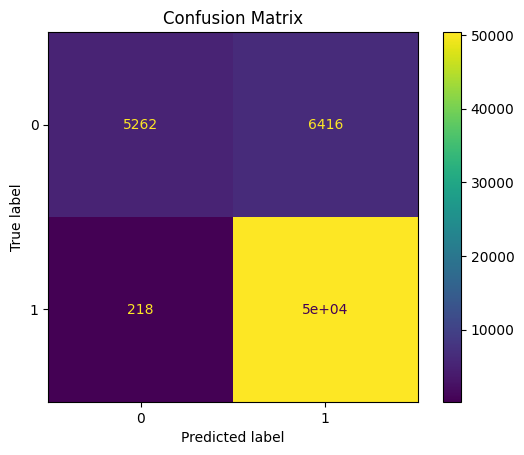

In [97]:
#Model Evaluation
print('Train Accuracy :', round(logreg_model.score(X_train, y_train), 2))
print('Train F1 Score:', round(f1_score(y_train, y_train_pred), 2))
print('Train Recall Score:', round(recall_score(y_train, y_train_pred), 2))
print('Train Precision Score:', round(precision_score(y_train, y_train_pred), 2))

print('\nTest Accuracy :', round(logreg_model.score(X_test, y_test), 2))
print('Test F1 Score:', round(f1_score(y_test, y_test_pred), 2))
print('Test Recall Score:', round(recall_score(y_test, y_test_pred), 2))
print('Test Precision Score:', round(precision_score(y_test, y_test_pred), 2))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [98]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.45      0.61     11678
           1       0.89      1.00      0.94     50601

    accuracy                           0.89     62279
   macro avg       0.92      0.72      0.78     62279
weighted avg       0.90      0.89      0.88     62279



* Here the recall value for the 'charged off' is very low, Hence will build a better model

**Model-2**

In [100]:
# Oversampling to balance the target variable

sm=SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train.ravel())

print(f"Before OverSampling, count of label 1: {sum(y_train == 1)}")
print(f"Before OverSampling, count of label 0: {sum(y_train == 0)}")
print(f"After OverSampling, count of label 1: {sum(y_train_res == 1)}")
print(f"After OverSampling, count of label 0: {sum(y_train_res == 0)}")

Before OverSampling, count of label 1: 202401
Before OverSampling, count of label 0: 46712
After OverSampling, count of label 1: 202401
After OverSampling, count of label 0: 202401


Train Accuracy : 0.79
Train F1 Score: 0.86
Train Recall Score: 0.79
Train Precision Score: 0.95

Test Accuracy : 0.8
Test F1 Score: 0.86
Test Recall Score: 0.79
Test Precision Score: 0.95


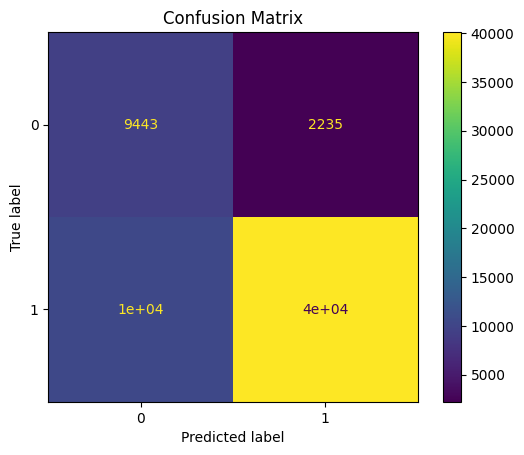

In [101]:
model = LogisticRegression()
model.fit(X_train_res, y_train_res)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

#Model Evaluation
print('Train Accuracy :', round(model.score(X_train, y_train), 2))
print('Train F1 Score:', round(f1_score(y_train, train_preds), 2))
print('Train Recall Score:', round(recall_score(y_train, train_preds), 2))
print('Train Precision Score:', round(precision_score(y_train, train_preds), 2))

print('\nTest Accuracy :', round(model.score(X_test, y_test), 2))
print('Test F1 Score:', round(f1_score(y_test, test_preds), 2))
print('Test Recall Score:', round(recall_score(y_test, test_preds), 2))
print('Test Precision Score:', round(precision_score(y_test, test_preds), 2))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [102]:
y_pred = test_preds
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.47      0.81      0.60     11678
           1       0.95      0.79      0.86     50601

    accuracy                           0.80     62279
   macro avg       0.71      0.80      0.73     62279
weighted avg       0.86      0.80      0.81     62279



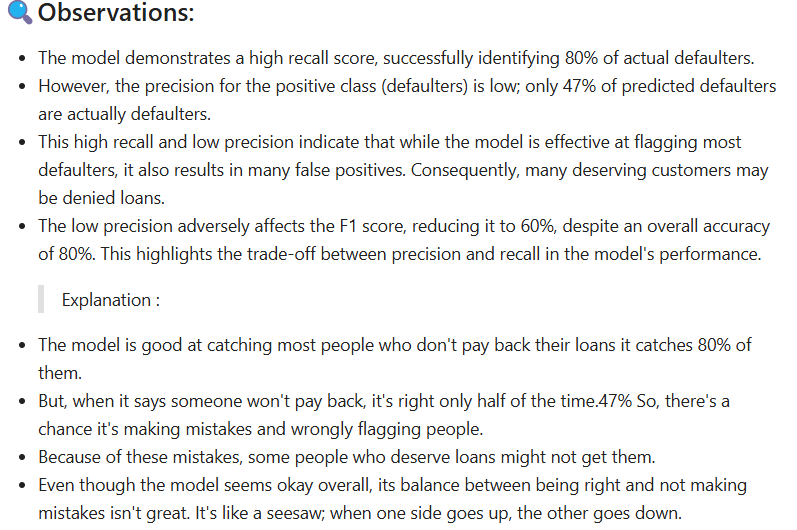

In [103]:
#Try with different regularization factor lamda and choose the best to build the model

lamb = np.arange(0.01, 1000, 10)

train_scores = []
test_scores = []

for lam in lamb:
    model = LogisticRegression(C = 1/lam)
    model.fit(X_train, y_train)

    tr_score = model.score(X_train, y_train)
    te_score = model.score(X_test, y_test)

    train_scores.append(tr_score)
    test_scores.append(te_score)

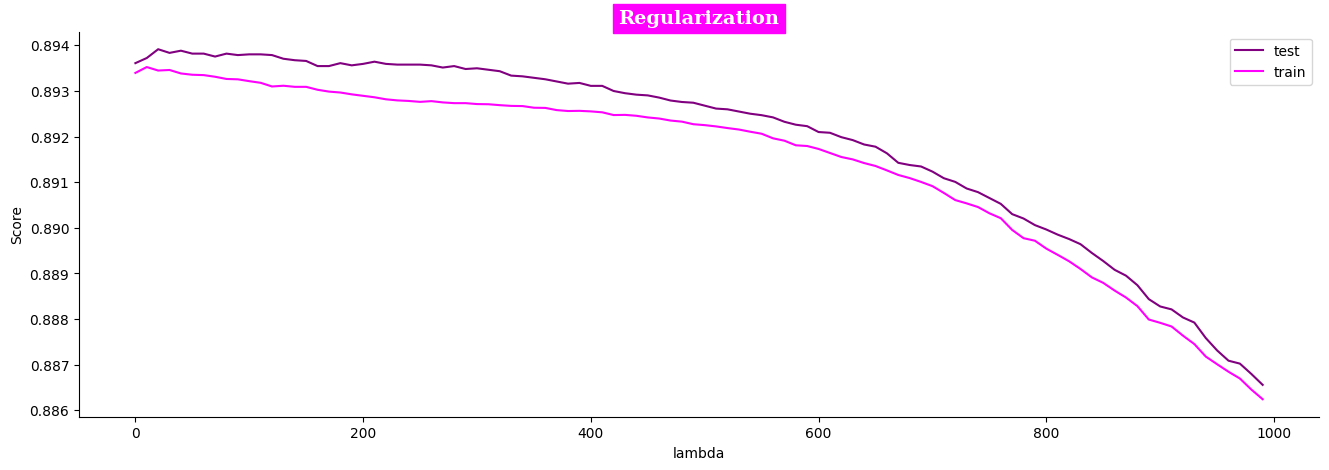

In [104]:
#Plot the train and test scores with respect lambda values i.e. regularization factors
ran = np.arange(0.01, 1000, 10)
plt.figure(figsize=(16,5))
sns.lineplot(x=ran,y=test_scores,color='purple',label='test')
sns.lineplot(x=ran,y=train_scores,color='magenta',label='train')
plt.title('Regularization',fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='magenta',color='w')
plt.xlabel("lambda")
plt.ylabel("Score")
sns.despine()
plt.show()

In [105]:
#Check the index of best test score and the check the best test score

print(np.argmax(test_scores))
print(test_scores[np.argmax(test_scores)])

2
0.8939128759292859


In [106]:
#Calculate the best lambda value based on the index of best test score

best_lamb = 0.01 + (10*2)
best_lamb

20.01

In [107]:
lamdba = np.argmax(test_scores)

In [108]:
#Fit the model using best lambda

reg_model = LogisticRegression(C=1/best_lamb)
reg_model.fit(X_train, y_train)

LogisticRegression(C=0.04997501249375312)

In [111]:
#Predict the y_values and y_probability values

y_reg_pred = reg_model.predict(X_test)
y_reg_pred_proba = reg_model.predict_proba(X_test)

In [112]:
#Print model score

print(f'Logistic Regression Model Score with best lambda: ',end='')
print(round(model.score(X_test, y_test)*100,2),'%')

Logistic Regression Model Score with best lambda: 88.66 %


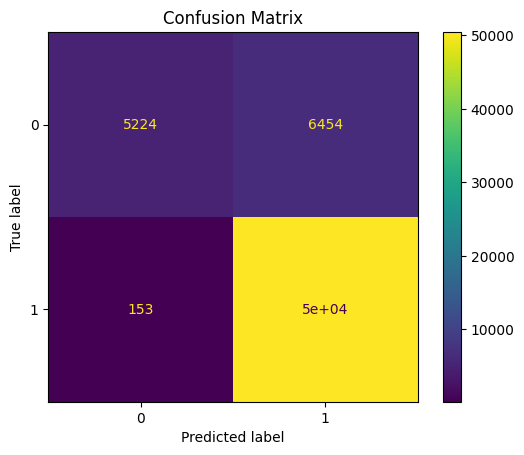

In [113]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_reg_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [114]:
print(classification_report(y_test, y_reg_pred))

              precision    recall  f1-score   support

           0       0.97      0.45      0.61     11678
           1       0.89      1.00      0.94     50601

    accuracy                           0.89     62279
   macro avg       0.93      0.72      0.78     62279
weighted avg       0.90      0.89      0.88     62279



**Observations from classification report:**
  * Regularized model

* Precision : 89%
* Recall : 100%
* F1-score : 94%
* Accuracy : 89%

# K-fold - Cross_validation

   *  cross validation accuracy has to be approx 89%

In [115]:
x=scaler.fit_transform(X)

kfold = KFold(n_splits=10)
accuracy = np.mean(cross_val_score(reg_model,x,y,cv=kfold,scoring='accuracy'))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.894


In [116]:
cm = confusion_matrix(y_test, y_reg_pred)
cm_df = pd.DataFrame(cm, index=['Defaulter','Fully paid'], columns=['Defaulter','Fully paid'])
cm_df

,Defaulter,Fully paid
Defaulter,5224,6454
Fully paid,153,50448


**Insights**:
* TN = 5223 (True Negative: Correctly predicted Charged Off)
* TP = 50450 (True Positive: Correctly predicted Fully Paid)
* FP = 6455 (False Positive: Predicted Fully Paid but actually Charged Off)
* FN = 151 (False Negative: Predicted Charged Off but actually Fully Paid)
* Actual Negative (Charged Off) = 5223 + 6455 = 11678
* Actual Positive (Fully Paid) = 151 + 50450 = 50601
* Predicted Negative (Charged Off) = 5223 + 151 = 5374
* Predicted Positive (Fully Paid) = 6455 + 50450 = 56905

In [117]:
#Collect the model coefficients and print those in dataframe format
coeff_df = pd.DataFrame()
coeff_df['Features'] = X_train_res.columns
coeff_df['Weights'] = model.coef_[0]
coeff_df['ABS_Weights'] = abs(coeff_df['Weights'])
coeff_df = coeff_df.sort_values(['ABS_Weights'], ascending=False)
coeff_df

,Features,Weights,ABS_Weights
13,zipcode_11650,-2.205071,2.205071
20,zipcode_93700,-2.199511,2.199511
19,zipcode_86630,-2.187202,2.187202
12,zipcode_05113,1.349854,1.349854
15,zipcode_29597,1.345002,1.345002
2,int_rate,-0.647268,0.647268
5,dti,-0.533302,0.533302
24,grade_E,-0.464009,0.464009
4,annual_inc,0.460678,0.460678
1,term,-0.432346,0.432346


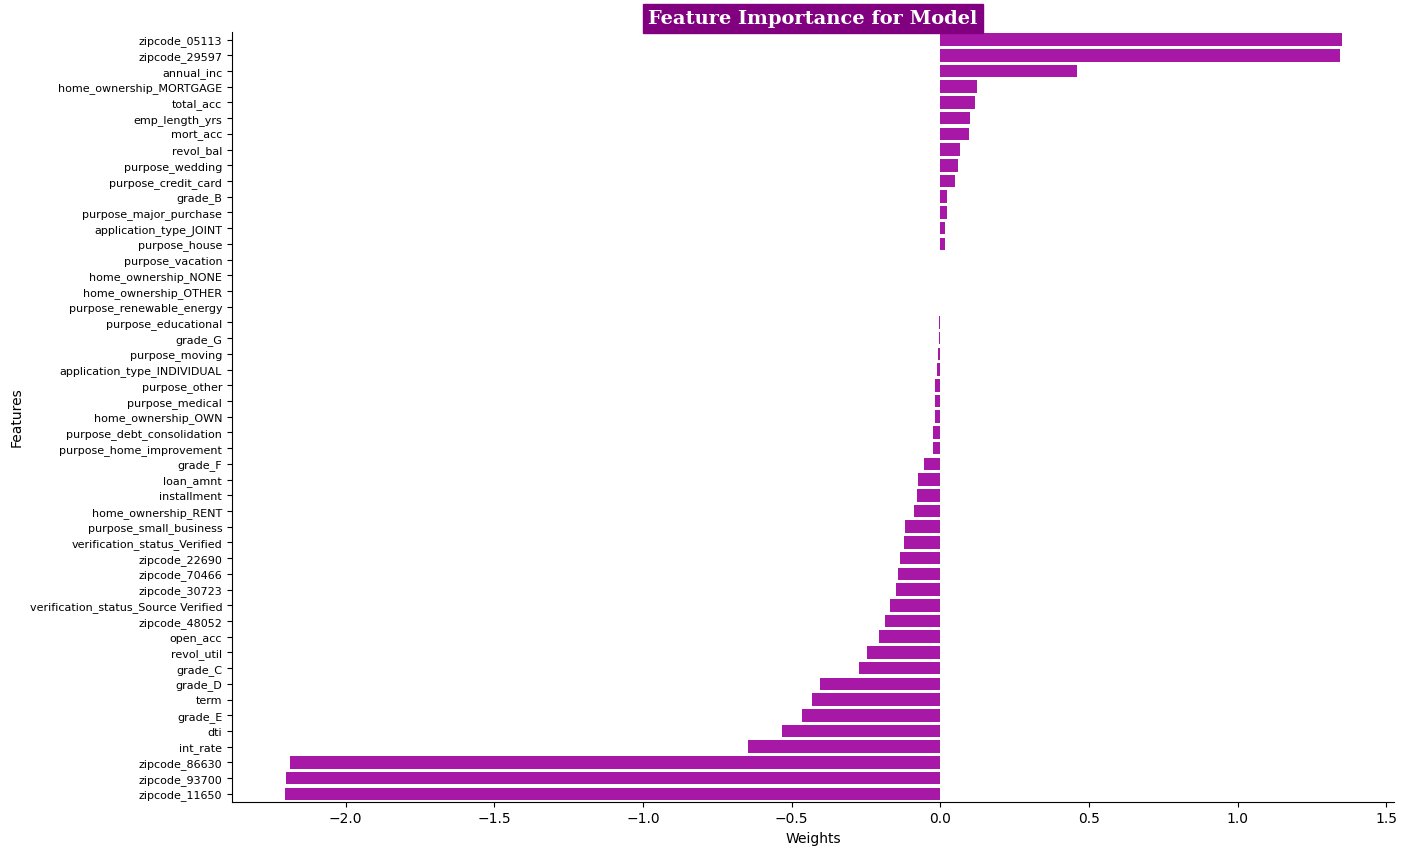

In [118]:
imp_feature = coeff_df.sort_values(by='Weights',ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(y = imp_feature['Features'],
           x = imp_feature['Weights'],color='m')
plt.title("Feature Importance for Model",fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='purple',color='w')
plt.xlabel("Weights")
plt.yticks(fontsize=8)
plt.ylabel("Features")
sns.despine()
plt.show()

In [119]:
#Logistic Regression model intercept

model.intercept_

array([2.52298763])

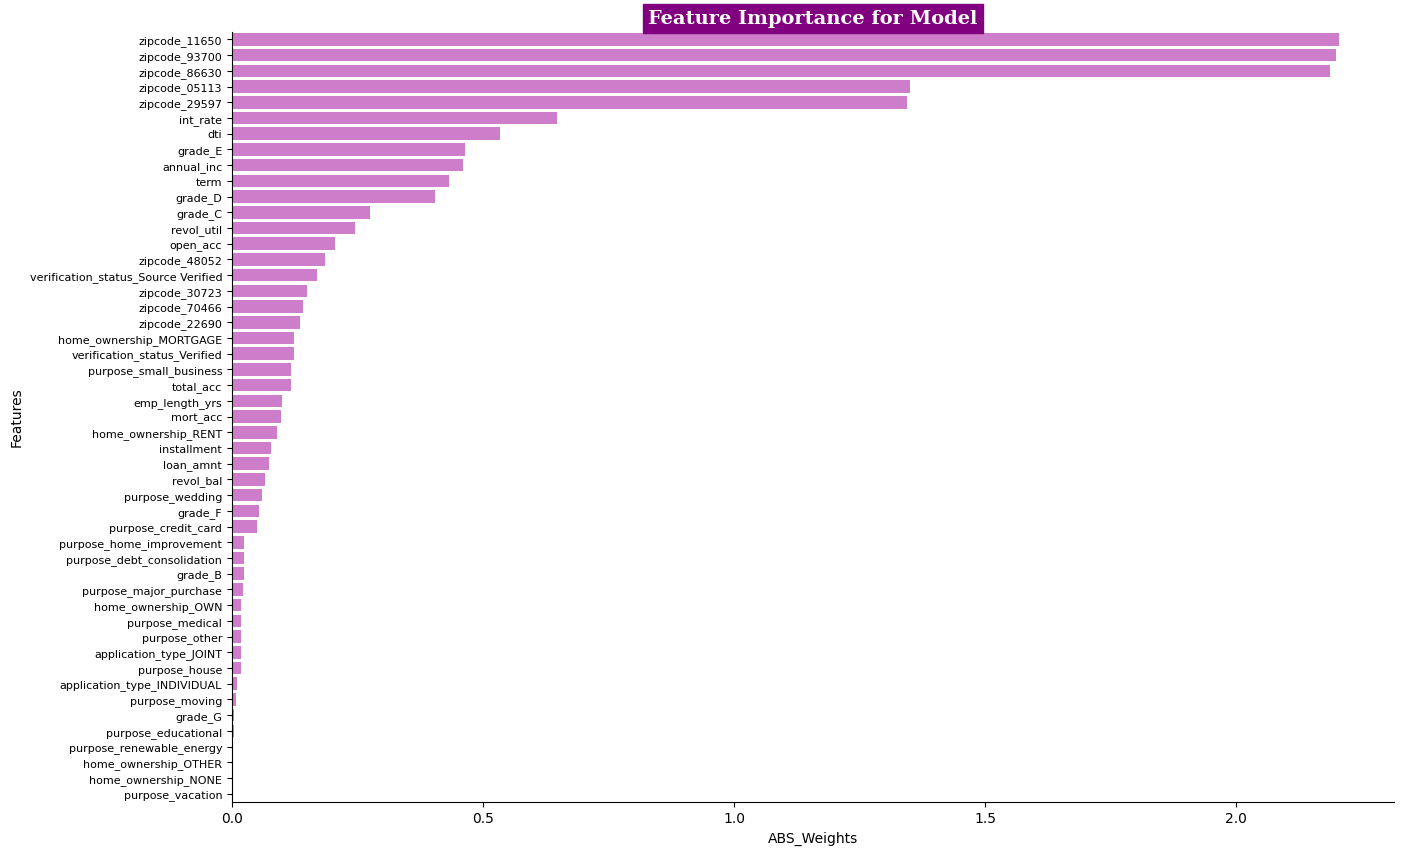

In [120]:
plt.figure(figsize=(15,10))
sns.barplot(y = coeff_df['Features'],x = coeff_df['ABS_Weights'],color='orchid')
plt.title("Feature Importance for Model",fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='purple',color='w')
plt.xlabel("ABS_Weights")
plt.yticks(fontsize=8)
plt.ylabel("Features")
sns.despine()
plt.show()

**Observations**:
* The model has assigned significant weight to the zip_code, Annual Income, grade features, indicating that certain zip codes strongly influence the prediction of defaulters.
* Features such as dti (debt-to-income ratio), open_acc (number of open accounts), and loan_amnt (loan amount) also have high positive coefficients, highlighting their importance in predicting default risk.
* On the other hand, several zip codes have large negative coefficients, suggesting that they are associated with a lower likelihood of default.

 **ROC AUC curve**

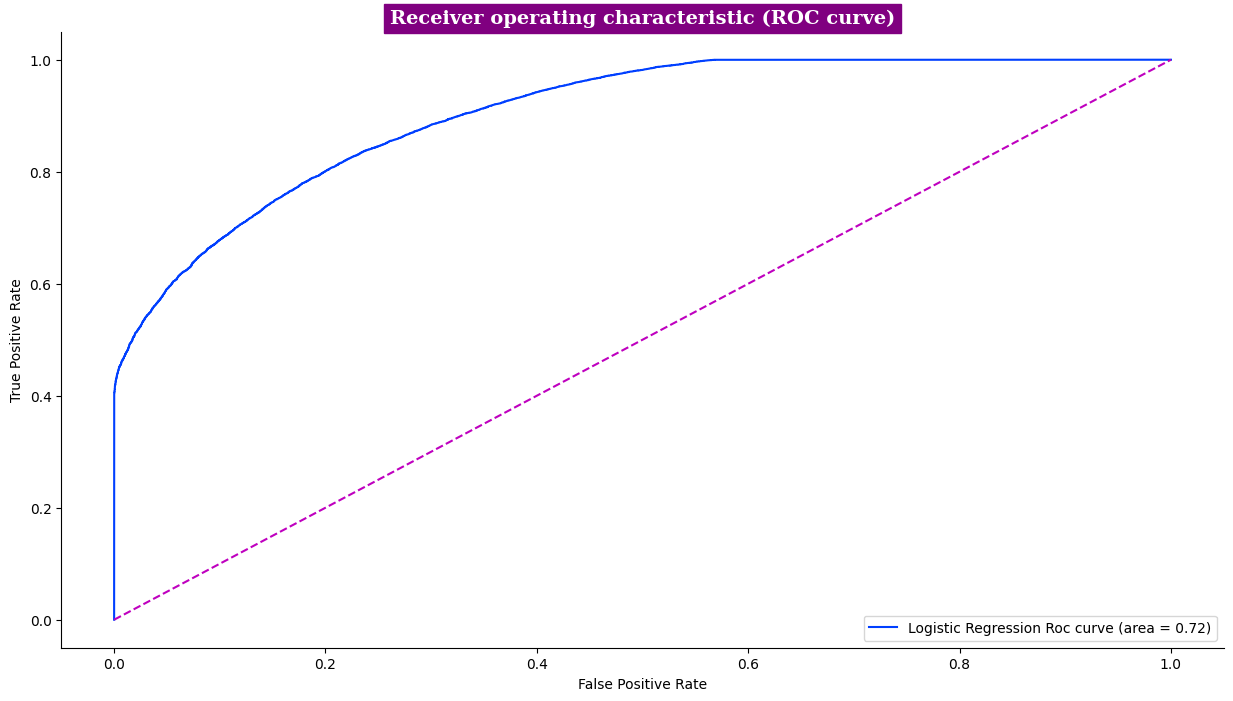

In [121]:
# area under ROC curve
logit_roc_auc = roc_auc_score(y_test,y_reg_pred)

# Compute the false positive rate, true positive rate, and thresholds
fpr,tpr,thresholds = roc_curve(y_test,y_reg_pred_proba[:,1])

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(15,8))
plt.plot(fpr,tpr,label='Logistic Regression Roc curve (area = %0.2f)'% logit_roc_auc)
plt.plot([0,1],[0,1],'m--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)',fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='purple',color='w')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [122]:
logit_roc_auc

np.float64(0.7221566085466022)

In [123]:
roc_auc = auc(fpr, tpr)
roc_auc

np.float64(0.9036968310880946)

**Insights**:
**Trade-off in Performance**: The ROC curve area, representing model performance, is 72%. This indicates that the model effectively distinguishes between classes 72% of the time.

* Ideally, we aim for a higher True Positive Rate (TPR) and a lower False Positive Rate (FPR) to ensure accurate predictions.

* The ROC curve illustrates that as True Positives increase, there's a simultaneous increase in False Positives.

* Misclassification: This trade-off implies that while identifying more Fully Paid customers, there's a heightened risk of misclassifying Charged Off customers as Fully Paid, potentially leading to Non-Performing Assets (NPAs).

These points emphasize the need to mitigate this risk:

* Reducing FPR while maintaining TPR is crucial to minimize misclassifications and associated risks.
* By shifting False Positives towards the left on the ROC curve, the model's overall performance, as measured by AUC, can improve.
* This improvement in AUC relies on maintaining a high True Positive Rate while reducing False Positives.

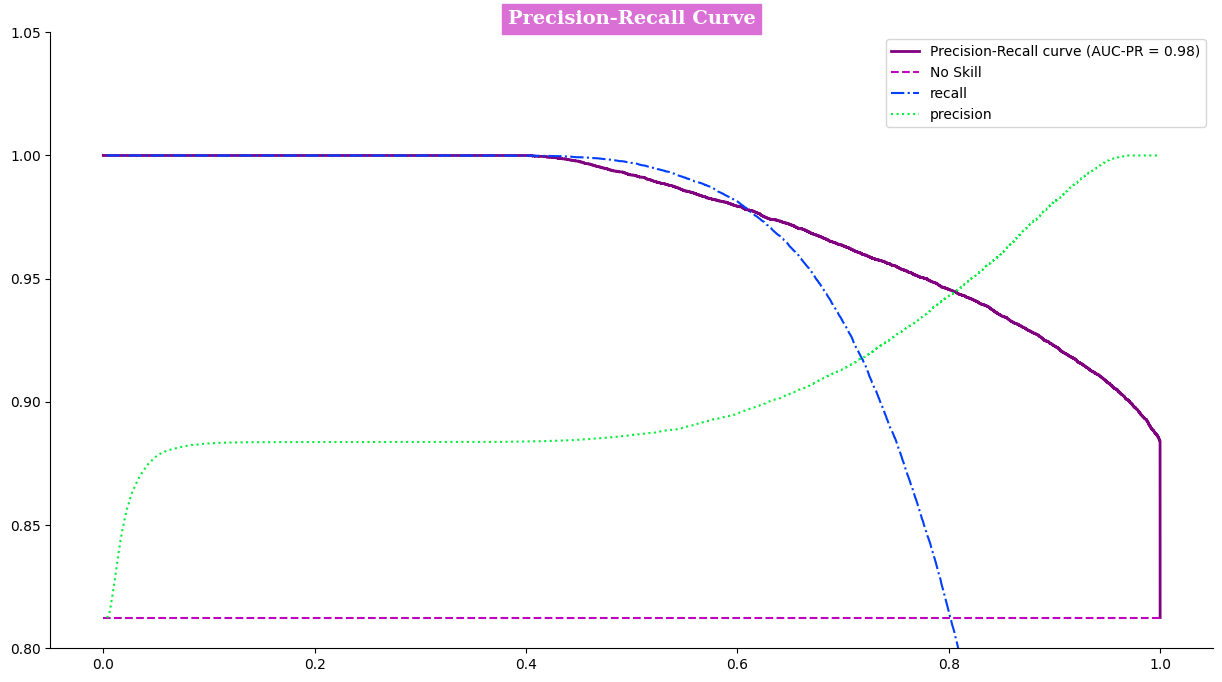

In [124]:
precision, recall, thresholds = precision_recall_curve(y_test, y_reg_pred_proba[:,1])

average_precision = average_precision_score(y_test, y_reg_pred_proba[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(15,8))
plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (AUC-PR = {average_precision:.2f})')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color='m')
plt.plot(thresholds, recall[0:thresholds.shape[0]], label='recall',linestyle='-.')
plt.plot(thresholds, precision[0:thresholds.shape[0]], label='precision',linestyle='dotted')
# plt.xlim([0.0, 1.0])
plt.ylim([0.8, 1.05])
plt.title('Precision-Recall Curve',fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='orchid',color='w')
plt.legend(loc='upper right')
sns.despine()
plt.show()

In [125]:
auc(recall, precision).round(3)

np.float64(0.975)

**Insight**:

* The Area Under the Curve (AUC) for the precision-recall curve is 0.975. This high AUC value suggests that the model achieves excellent performance in distinguishing between positive and negative classes, showcasing strong precision-recall characteristics.
* Precision-Recall Curve Superiority: Precision-recall curves are pivotal, especially in imbalanced datasets, focusing on accurate predictions of the relevant class (Class 1 - Fully paid in this case).

* Irrelevance of True Negatives: Precision and recall computations disregard true negatives, simplifying focus to the correct prediction of Fully Paid customers.

* AUC Strengthens Model Evaluation: A high AUC (97.5%) underscores the model's robustness in distinguishing between classes, indicating its efficacy.

* Precision Enhancement Priority: Optimal model refinement centers on elevating precision by minimizing False Positives, vital for improving overall performance and mitigating risks.

In [126]:
# balenced Model
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

lr_model = lr.fit(X_train, y_train)

print(classification_report(y_test, lr_model.predict(X_test)))

cm_bal = confusion_matrix(y_test, lr_model.predict(X_test))
cm_bal_df = pd.DataFrame(cm_bal, index=['Defaulter','Fully paid'], columns=['Defaulter','Fully paid'])
cm_bal_df

              precision    recall  f1-score   support

           0       0.47      0.81      0.60     11678
           1       0.95      0.79      0.86     50601

    accuracy                           0.79     62279
   macro avg       0.71      0.80      0.73     62279
weighted avg       0.86      0.79      0.81     62279



,Defaulter,Fully paid
Defaulter,9468,2210
Fully paid,10586,40015


**Observations from classification report**:
Balenced model

* Precision : 95%
* Recall : 79%
* F1-score : 86%
* Accuracy : 79%


**Insights**:
* TN = 9466 (True Negative: Correctly predicted Charged Off)
* TP = 40028 (True Positive: Correctly predicted Fully Paid)
* FP = 2212 (False Positive: Predicted Fully Paid but actually Charged Off)
* FN = 10573 (False Negative: Predicted Charged Off but actually Fully Paid)
* Actual Negative (Charged Off) = 9466 + 2212 = 11678
* Actual Positive (Fully Paid) = 10573 + 40028 = 50601
* Predicted Negative (Charged Off) = 9466 + 10573 = 20039
* Predicted Positive (Fully Paid) = 2212 + 40028 = 42240

In [127]:
lr_model.intercept_

array([6.35580168])

# Q6: Thinking from a bank's perspective, which metric should our primary focus be on..

From a bank's perspective, minimizing risks and maximizing profitability are paramount. ROC AUC (Receiver Operating Characteristic Area Under Curve) is indeed a crucial metric because it encompasses both True Positive Rate (TPR) and False Positive Rate (FPR)

* Bank's primary focus should be on ROC AUC , because bank needs to reduce FPR (False Positive Rate) and needs to increase the TPR (True Positive Rate).
* Maximizing TPR ensures that the bank correctly identifies customers who fully pay their loans (reducing False Negatives), while minimizing FPR ensures that the bank doesn't wrongly classify customers as fully paid when they're actually charged off (reducing False Positives).

* By optimizing ROC AUC, the bank can strike a balance between correctly identifying creditworthy customers and minimizing the risk of defaulters, thereby enhancing the overall performance and reliability of its credit scoring model.

* since I'm having High Recall value of 100% in Regularized model(most efficient model:
From a bank's perspective, the primary focus should be on minimizing risks while maximizing profitability. Therefore, the most relevant metric would be Precision.

* Precision represents the proportion of correctly predicted positive instances (e.g., customers who fully pay their loans) out of all instances predicted as positive. In the context of a bank, precision reflects the accuracy of identifying creditworthy customers who are likely to repay their loans. Maximizing precision ensures that the bank minimizes the number of false positives, which are instances where the bank incorrectly identifies customers as creditworthy when they are not. By prioritizing precision, the bank can reduce the risk of loan defaults and associated financial losses.

* While ROC AUC, Recall, and F1 Score are also important metrics, precision aligns closely with the bank's objective of minimizing risks and ensuring the quality of its loan portfolio.

# Q7. How does the gap in precision and recall affect the bank?

* To comprehend the errors made by a model, it's crucial to evaluate both false positives and false negatives, which are gauged through metrics like recall and precision. When recall is low, it poses a significant risk for the bank.
* So, the gap between precision and recall will affect the bank. As the gap widens, there will be increase in incorrect predictions.
* Good precision means less False Positives. i.e. Less NPA loan accounts.
* Good recall means less False Negatives. i.e. not loosing on good customer.

# Q8. Which were the features that heavily affected the outcome?

* Address(Zipcode), Annual_Income, Grade seems to be most important feature in our case.

* Loan duration term, Total Credit balance revol_bal, : Monthly debt vs. monthly income ratio dti, Interest int_rate also has high weights(coeffients) in the model .

# Q9. Will the results be affected by geographical location? (Yes/No)

* Yes, we can see that zip_code (Address) is a very important feature so geographical location has impact on our result.

**Business Recommendations for LoanTap**

* Focus on maximizing the F1 score and area under the Precision-Recall Curve to
effectively manage the precision-recall trade-off. This ensures identifying most defaulters while reducing false positives, enhancing risk management.

* Consider using more complex classifiers like Random Forests or XGBoost and perform hyperparameter tuning to enhance model performance and capture intricate relationships in the data.

* Employed stratified k-fold cross-validation to ensure representative distribution of minority class in each fold, providing reliable estimates of model performance.
  * Policy Adjustments Based on Insights

  * Cross-Validation:

  * Model Improvement:

  * Optimize Loan Approval Strategy:

* Scrutinize loans with lower grades more rigorously and consider adjusting interest rates to compensate for higher risk.
* Implement targeted strategies for high-risk zip codes, such as additional verification steps or higher interest rates.
* Evaluate small business loans with additional financial health checks and collateral requirements to mitigate default risk.

By implementing these recommendations, LoanTap can enhance their loan approval process, minimize the risk of NPAs, and ensure sustainable growth and financial stability.